# Data Processing 3: Predicting Tones of Newspaper Headlines

## Online Appendix of "International News Coverage and Foreign Image Building"

### Gento Kato (Nov. 4, 2017)

*Back to [Summary Page](v3_SummaryNotebook.ipynb)*

In [1]:
#################################################################################
## File Name: v3_Data3_SupervisedLearning.py                                   ##
## Creation Date: 4 Nov 2016                                                   ##
## Author: Gento Kato                                                          ##
## Project: Foreign Image News Project                                         ##
## Purpose: Apply Supevised Learning                                           ##
#################################################################################

## Function for Jupyter Notebook ##

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In this section, two supervised learning methods -- logit and random forest -- are used to predict the appearnce of negative and positive sentiment in newspaper headlines. Using the word appearnce matrix data, we learn manually-coded negative and positive sentiments. 1000 cases in the full dataset for each country have manual codes. Therefore, I use randomly selected 80% of coded cases (or 800 cases) as trainig set to tune parameter values for each method [Subsection 2], and assess their performance on remaining 20% of coded cases (or 200 cases) [Subsection 3]. In the fourth subsection, I predict the coding for full dataset using both methods and discuss and compare the characteristics of two predictions. The last subsection presents the code to export data. 

## 1. Prepare Datasets and Methods

### 1.1 Import Required Modules

To start with, we import python 2 modules that are necessary for the analysis. I use <code>numpy</code>, <code>pandas</code> for the data manipulation, <code>sklearn</code> for various classification methods, and <code>matplotlib</code> for result visualization. Also, the session is temporarilly saved by using <code>shelve</code> module. Lastly, I import user-defined functions from <code>gentokfunc.py</code> file in <code>codes</code> directory. 

In [101]:
#################################
## 1.1 Import Required Modules ##
#################################

#%reset # If executable, clear the workspace

# Computation Timer
from timeit import default_timer as trec

## Data Mining
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Classification Method
import sklearn.linear_model as skl_lm ## Linear Methods (Logit)
from sklearn.ensemble import RandomForestClassifier ## Meta-Methods

## Model Selection and Metrics
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve
from sklearn.metrics import auc, roc_auc_score, average_precision_score

## User Defined Classification Functions
import sys; sys.path.insert(0, '../codes/') ## If codes path not on sys.path
import gentokfunc as gk; gk = reload(gk) # This is the file for user defined functions
from gentokfunc import MidpointNormalize # class for plotting validation result

## Saving & Loading Objects
import shelve

### 1.2 Load Data

The original data come in two forms. First, <code>usdata.csv</code>, <code>chndata.csv</code>, <code>skodata.csv</code>, and <code>nkodata.csv</code> include the coding for each headline. Second, <code>usWrdMat.csv</code>, <code>chnWrdMat.csv</code>, <code>skoWrdMat.csv</code>, and <code>nkoWrdMat.csv</code> are the word frequency matrixes for classification.

In [3]:
###################
## 1.2 Load Data ##
###################

## US Data
usdata = pd.read_csv("../data/usdata.csv", encoding='CP932') # Coding 
usWrdMat = pd.read_csv("../data_heavy/usWrdMat.csv", encoding='CP932') # Word Matrix
## China Data
chndata = pd.read_csv("../data/chndata.csv", encoding='CP932') # Coding
chnWrdMat = pd.read_csv("../data_heavy/chnWrdMat.csv", encoding='CP932') # Word Matrix
## South Korea Data
skodata = pd.read_csv("../data/skordata.csv", encoding='CP932') # Coding
skoWrdMat = pd.read_csv("../data_heavy/skorWrdMat.csv", encoding='CP932') # Word Matrix
## North Korea Data
nkodata = pd.read_csv("../data/nkordata.csv", encoding='CP932') # Coding
nkoWrdMat = pd.read_csv("../data_heavy/nkorWrdMat.csv", encoding='CP932') # Word Matrix

### 1.3 Create Training Set and Test Set

From the original data, I first extract 1000 rows that have values for manually-coded negative sentiment (1 = negative, 0 = not negative) and positive sentiment (1 = positive, 0 = not positive). Then, to conduct and assess classification methods in following subsections, we split the coded data into training set and test set, with test set being 20% of the coded data. The below tables describe the manual-coding distribution in training set and test set for each country. 

#### 1.3.1 US Data

In [4]:
#################################
## 1.3.1 Train Test Split (US) ##
#################################

# Set X and y for Classification
targetx = usWrdMat
targety = usdata

# Create Design Matrix
X_us = np.array(targetx.loc[targety['train_us'] == 1,:])
y_us_neg = np.array(targety.loc[targety['train_us'] == 1,'cdneg_us'])
y_us_pos = np.array(targety.loc[targety['train_us'] == 1,'cdpos_us'])

# Train-Test Split
X_train_us_neg, X_test_us_neg, y_train_us_neg, y_test_us_neg = train_test_split(X_us, y_us_neg, test_size=0.2, random_state=237843)
X_train_us_pos, X_test_us_pos, y_train_us_pos, y_test_us_pos = train_test_split(X_us, y_us_pos, test_size=0.2, random_state=2366)


In [5]:
# Display Frequency Table
pd.DataFrame({'Train Set (Negative)':np.array(pd.Series(y_train_us_neg).value_counts()),
              'Test Set (Negative)':np.array(pd.Series(y_test_us_neg).value_counts()),
              'Train Set (Positive)':np.array(pd.Series(y_train_us_pos).value_counts()),
              'Test Set (Positive)':np.array(pd.Series(y_test_us_pos).value_counts())}, 
              index = ["0", "1"], 
              columns = ['Train Set (Negative)','Test Set (Negative)',
                         'Train Set (Positive)','Test Set (Positive)',]).transpose()

0    1
Train Set (Negative)  571  218
Test Set (Negative)   144   54
Train Set (Positive)  688  101
Test Set (Positive)   164   34

#### 1.3.2 China Data

In [6]:
####################################
## 1.3.2 Train Test Split (China) ##
####################################

# Set X and y for Classification
targetx = chnWrdMat
targety = chndata

# Create Design Matrix
X_chn = np.array(targetx.loc[targety['train_chn'] == 1,:])
y_chn_neg = np.array(targety.loc[targety['train_chn'] == 1,'cdneg_chn'])
y_chn_pos = np.array(targety.loc[targety['train_chn'] == 1,'cdpos_chn'])

# Train-Test Split
X_train_chn_neg, X_test_chn_neg, y_train_chn_neg, y_test_chn_neg = train_test_split(X_chn, y_chn_neg, test_size=0.2, random_state=237843)
X_train_chn_pos, X_test_chn_pos, y_train_chn_pos, y_test_chn_pos = train_test_split(X_chn, y_chn_pos, test_size=0.2, random_state=2366)


In [7]:
# Display Frequency Table
pd.DataFrame({'Train Set (Negative)':np.array(pd.Series(y_train_chn_neg).value_counts()),
              'Test Set (Negative)':np.array(pd.Series(y_test_chn_neg).value_counts()),
              'Train Set (Positive)':np.array(pd.Series(y_train_chn_pos).value_counts()),
              'Test Set (Positive)':np.array(pd.Series(y_test_chn_pos).value_counts())}, 
              index = ["0", "1"], 
              columns = ['Train Set (Negative)','Test Set (Negative)',
                         'Train Set (Positive)','Test Set (Positive)',]).transpose()

0    1
Train Set (Negative)  604  192
Test Set (Negative)   139   61
Train Set (Positive)  700   96
Test Set (Positive)   176   24

#### 1.3.3 South Korea Data

In [8]:
##########################################
## 1.3.3 Train Test Split (South Korea) ##
##########################################

## Set X and y for Classification
targetx = skoWrdMat
targety = skodata

# Create Design Matrix
X_sko = np.array(targetx.loc[targety['train_sko'] == 1,:])
y_sko_neg = np.array(targety.loc[targety['train_sko'] == 1,'cdneg_sko'])
y_sko_pos = np.array(targety.loc[targety['train_sko'] == 1,'cdpos_sko'])

# Train-Test Split
X_train_sko_neg, X_test_sko_neg, y_train_sko_neg, y_test_sko_neg = train_test_split(X_sko, y_sko_neg, test_size=0.2, random_state=237843)
X_train_sko_pos, X_test_sko_pos, y_train_sko_pos, y_test_sko_pos = train_test_split(X_sko, y_sko_pos, test_size=0.2, random_state=2366)


In [9]:
# Display Frequency Table
pd.DataFrame({'Train Set (Negative)':np.array(pd.Series(y_train_sko_neg).value_counts()),
              'Test Set (Negative)':np.array(pd.Series(y_test_sko_neg).value_counts()),
              'Train Set (Positive)':np.array(pd.Series(y_train_sko_pos).value_counts()),
              'Test Set (Positive)':np.array(pd.Series(y_test_sko_pos).value_counts())}, 
              index = ["0", "1"], 
              columns = ['Train Set (Negative)','Test Set (Negative)',
                         'Train Set (Positive)','Test Set (Positive)',]).transpose()

0   1
Train Set (Negative)  699  95
Test Set (Negative)   183  16
Train Set (Positive)  712  82
Test Set (Positive)   176  23

#### 1.3.4 North Korea Data

In [10]:
##########################################
## 1.3.4 Train Test Split (North Korea) ##
##########################################

# Set X and y for Classification
targetx = nkoWrdMat
targety = nkodata

# Create Design Matrix
X_nko = np.array(targetx.loc[targety['train_nko'] == 1,:])
y_nko_neg = np.array(targety.loc[targety['train_nko'] == 1,'cdneg_nko'])
y_nko_pos = np.array(targety.loc[targety['train_nko'] == 1,'cdpos_nko'])

# Train-Test Split
X_train_nko_neg, X_test_nko_neg, y_train_nko_neg, y_test_nko_neg = train_test_split(X_nko, y_nko_neg, test_size=0.2, random_state=237843)
X_train_nko_pos, X_test_nko_pos, y_train_nko_pos, y_test_nko_pos = train_test_split(X_nko, y_nko_pos, test_size=0.2, random_state=2366)


In [11]:
# Display Frequency Table
pd.DataFrame({'Train Set (Negative)':np.array(pd.Series(y_train_nko_neg).value_counts()),
              'Test Set (Negative)':np.array(pd.Series(y_test_nko_neg).value_counts()),
              'Train Set (Positive)':np.array(pd.Series(y_train_nko_pos).value_counts()),
              'Test Set (Positive)':np.array(pd.Series(y_test_nko_pos).value_counts())}, 
              index = ["0", "1"], 
              columns = ['Train Set (Negative)','Test Set (Negative)',
                         'Train Set (Positive)','Test Set (Positive)',]).transpose()

0    1
Train Set (Negative)  382  377
Test Set (Negative)    95   95
Train Set (Positive)  618  141
Test Set (Positive)   152   38

## 2. Tune Parameter Values on Training Set

Using the training set generated in the previous subsection, I fit logit (with newton conjugate solver and ridge penalty) and random forest to classify tones. All classifications are made with dichotomous category. We describe the process of tuning parameters for each classification method, based on accuracy score. Otherwise noted, optimal parameter values are assessed with 5-fold cross validation using the training set.  The classification results on test set are compared and evaluated in the next subsection. 

### 2.1 Logistic Regression (With Newton Conjugate Solver & Ridge Penalty)

In the logistic regression with large number of variables, we can optimize the size of ridge penalty $\lambda$. In <code>scikit-learn</code> implementation of logistic regression, $C$ parameter is given as the inverse of $\lambda$ (larger $C$ indicates smaller penalty).  We consider the total of 10 parameter values $C \in  \{0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000\}$. 

#### 2.1.1 US Data (Negative)

Tuning:

In [12]:
################################################
## 2.1.1 Tune Logit Parameters (US, Negative) ##
################################################

## Logistic Regression
logit = skl_lm.LogisticRegression(solver='newton-cg')

## Tune C
start = trec()
params = {'C':[0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
optparam_logit_us_neg, optscore_logit_us_neg, values_logit_us_neg, scores_logit_us_neg = gk.class_optparam(X_train_us_neg, y_train_us_neg, logit, params = params)
time_logit_us_neg_tune = trec() - start
print('Computation time is %0.3f seconds' % time_logit_us_neg_tune)


Computation time is 32.005 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [13]:
## Print Optimal Parameter Values
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_logit_us_neg:
    print i, optparam_logit_us_neg[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_logit_us_neg)


From 5-Fold Cross Validation, the best parameter values are: 

C [1.0]

The corresponding accuracy score is 0.76928


The accuracy scores for the considered set of paremeter values can be plotted as follows:

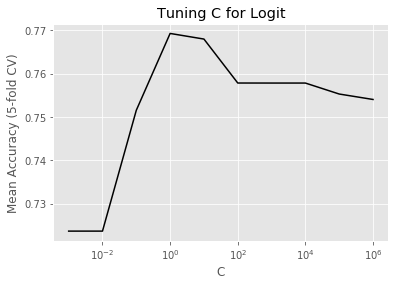

In [14]:
# Plotting Accuracy Score by C
plt.rcParams["figure.figsize"] = (6,4)
plt.semilogx(values_logit_us_neg, scores_logit_us_neg, 'k-')
plt.title('Tuning C for Logit')
plt.xlabel('C')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [15]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
logit = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_us_neg["C"][0])
logitfpr_us_neg, logittpr_us_neg, logitrocauc_us_neg, logitprec_us_neg, logitrec_us_neg, logitprauc_us_neg = gk.class_onestep_auc(X_train_us_neg, y_train_us_neg, X_test_us_neg, y_test_us_neg, logit)
time_logit_us_neg = trec() - start
print('Computation time is %0.3f seconds' % time_logit_us_neg)


Computation time is 0.732 seconds


#### 2.1.2 China Data (Negative)

Tuning:

In [16]:
###################################################
## 2.1.2 Tune Logit Parameters (China, Negative) ##
###################################################

## Logistic Regression
logit = skl_lm.LogisticRegression(solver='newton-cg')

## Tune C
start = trec()
params = {'C':[0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
optparam_logit_chn_neg, optscore_logit_chn_neg, values_logit_chn_neg, scores_logit_chn_neg = gk.class_optparam(X_train_chn_neg, y_train_chn_neg, logit, params = params)
time_logit_chn_neg_tune = trec() - start
print('Computation time is %0.3f seconds' % time_logit_chn_neg_tune)


Computation time is 22.175 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [17]:
## Print Optimal Parameter Values
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_logit_chn_neg:
    print i, optparam_logit_chn_neg[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_logit_chn_neg)


From 5-Fold Cross Validation, the best parameter values are: 

C [10.0]

The corresponding accuracy score is 0.82664


The accuracy scores for the considered set of paremeter values can be plotted as follows:

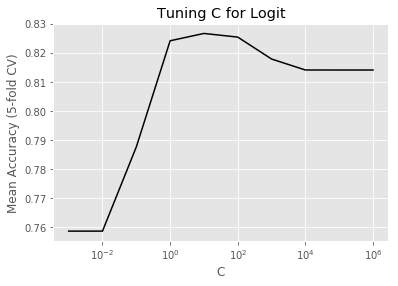

In [18]:
# Plotting Accuracy Score by C
plt.rcParams["figure.figsize"] = (6,4)
plt.semilogx(values_logit_chn_neg, scores_logit_chn_neg, 'k-')
plt.title('Tuning C for Logit')
plt.xlabel('C')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [19]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
logit = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_chn_neg["C"][0])
logitfpr_chn_neg, logittpr_chn_neg, logitrocauc_chn_neg, logitprec_chn_neg, logitrec_chn_neg, logitprauc_chn_neg = gk.class_onestep_auc(X_train_chn_neg, y_train_chn_neg, X_test_chn_neg, y_test_chn_neg, logit)
time_logit_chn_neg = trec() - start
print('Computation time is %0.3f seconds' % time_logit_chn_neg)


Computation time is 0.687 seconds


#### 2.1.3 South Korea Data (Negative)

Tuning:

In [20]:
#########################################################
## 2.1.3 Tune Logit Parameters (South Korea, Negative) ##
#########################################################

## Logistic Regression
logit = skl_lm.LogisticRegression(solver='newton-cg')

## Tune C
start = trec()
params = {'C':[0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
optparam_logit_sko_neg, optscore_logit_sko_neg, values_logit_sko_neg, scores_logit_sko_neg = gk.class_optparam(X_train_sko_neg, y_train_sko_neg, logit, params = params)
time_logit_sko_neg_tune = trec() - start
print('Computation time is %0.3f seconds' % time_logit_sko_neg_tune)


Computation time is 15.151 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [21]:
## Print Optimal Parameter Values
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_logit_sko_neg:
    print i, optparam_logit_sko_neg[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_logit_sko_neg)


From 5-Fold Cross Validation, the best parameter values are: 

C [100.0]

The corresponding accuracy score is 0.91564


The accuracy scores for the considered set of paremeter values can be plotted as follows:

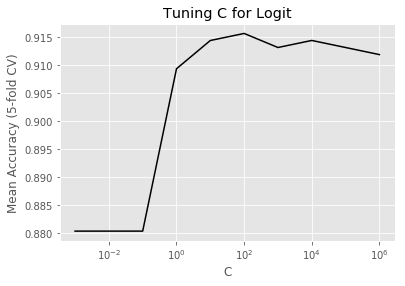

In [22]:
# Plotting Accuracy Score by C
plt.rcParams["figure.figsize"] = (6,4)
plt.semilogx(values_logit_sko_neg, scores_logit_sko_neg, 'k-')
plt.title('Tuning C for Logit')
plt.xlabel('C')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [23]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
logit = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_sko_neg["C"][0])
logitfpr_sko_neg, logittpr_sko_neg, logitrocauc_sko_neg, logitprec_sko_neg, logitrec_sko_neg, logitprauc_sko_neg = gk.class_onestep_auc(X_train_sko_neg, y_train_sko_neg, X_test_sko_neg, y_test_sko_neg, logit)
time_logit_sko_neg = trec() - start
print('Computation time is %0.3f seconds' % time_logit_sko_neg)


Computation time is 0.558 seconds


#### 2.1.4 North Korea Data (Negative)

Tuning:

In [24]:
#########################################################
## 2.1.4 Tune Logit Parameters (North Korea, Negative) ##
#########################################################

## Logistic Regression
logit = skl_lm.LogisticRegression(solver='newton-cg')

## Tune C
start = trec()
params = {'C':[0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
optparam_logit_nko_neg, optscore_logit_nko_neg, values_logit_nko_neg, scores_logit_nko_neg = gk.class_optparam(X_train_nko_neg, y_train_nko_neg, logit, params = params)
time_logit_nko_neg_tune = trec() - start
print('Computation time is %0.3f seconds' % time_logit_nko_neg_tune)


Computation time is 15.090 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [25]:
## Print Optimal Parameter Values
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_logit_nko_neg:
    print i, optparam_logit_nko_neg[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_logit_nko_neg)


From 5-Fold Cross Validation, the best parameter values are: 

C [0.1]

The corresponding accuracy score is 0.74178


The accuracy scores for the considered set of paremeter values can be plotted as follows:

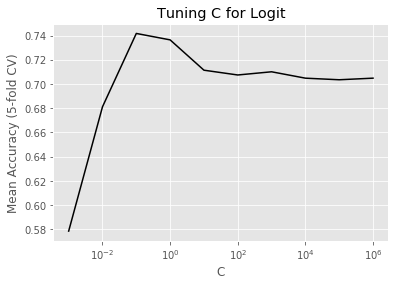

In [26]:
# Plotting Accuracy Score by C
plt.rcParams["figure.figsize"] = (6,4)
plt.semilogx(values_logit_nko_neg, scores_logit_nko_neg, 'k-')
plt.title('Tuning C for Logit')
plt.xlabel('C')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [27]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
logit = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_nko_neg["C"][0])
logitfpr_nko_neg, logittpr_nko_neg, logitrocauc_nko_neg, logitprec_nko_neg, logitrec_nko_neg, logitprauc_nko_neg = gk.class_onestep_auc(X_train_nko_neg, y_train_nko_neg, X_test_nko_neg, y_test_nko_neg, logit)
time_logit_nko_neg = trec() - start
print('Computation time is %0.3f seconds' % time_logit_nko_neg)


Computation time is 0.312 seconds


#### 2.1.5 US Data (Positive)

Tuning:

In [28]:
################################################
## 2.1.5 Tune Logit Parameters (US, Positive) ##
################################################

## Logistic Regression
logit = skl_lm.LogisticRegression(solver='newton-cg')

## Tune C
start = trec()
params = {'C':[0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
optparam_logit_us_pos, optscore_logit_us_pos, values_logit_us_pos, scores_logit_us_pos = gk.class_optparam(X_train_us_pos, y_train_us_pos, logit, params = params)
time_logit_us_pos_tune = trec() - start
print('Computation time is %0.3f seconds' % time_logit_us_pos_tune)


Computation time is 33.940 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [29]:
## Print Optimal Parameter Values
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_logit_us_pos:
    print i, optparam_logit_us_pos[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_logit_us_pos)


From 5-Fold Cross Validation, the best parameter values are: 

C [0.001, 0.01]

The corresponding accuracy score is 0.87201


The accuracy scores for the considered set of paremeter values can be plotted as follows:

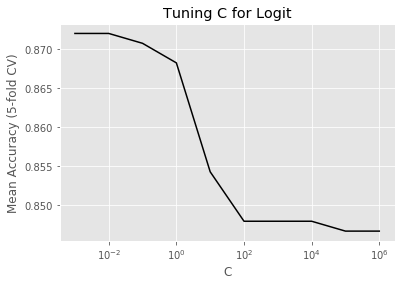

In [30]:
# Plotting Accuracy Score by C
plt.rcParams["figure.figsize"] = (6,4)
plt.semilogx(values_logit_us_pos, scores_logit_us_pos, 'k-')
plt.title('Tuning C for Logit')
plt.xlabel('C')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [31]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
logit = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_us_pos["C"][0])
logitfpr_us_pos, logittpr_us_pos, logitrocauc_us_pos, logitprec_us_pos, logitrec_us_pos, logitprauc_us_pos = gk.class_onestep_auc(X_train_us_pos, y_train_us_pos, X_test_us_pos, y_test_us_pos, logit)
time_logit_us_pos = trec() - start
print('Computation time is %0.3f seconds' % time_logit_us_pos)


Computation time is 0.436 seconds


#### 2.1.6 China Data (Positive)

Tuning:

In [32]:
###################################################
## 2.1.6 Tune Logit Parameters (China, Positive) ##
###################################################

## Logistic Regression
logit = skl_lm.LogisticRegression(solver='newton-cg')

## Tune C
start = trec()
params = {'C':[0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
optparam_logit_chn_pos, optscore_logit_chn_pos, values_logit_chn_pos, scores_logit_chn_pos = gk.class_optparam(X_train_chn_pos, y_train_chn_pos, logit, params = params)
time_logit_chn_pos_tune = trec() - start
print('Computation time is %0.3f seconds' % time_logit_chn_pos_tune)


Computation time is 21.781 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [33]:
## Print Optimal Parameter Values
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_logit_chn_pos:
    print i, optparam_logit_chn_pos[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_logit_chn_pos)


From 5-Fold Cross Validation, the best parameter values are: 

C [1.0]

The corresponding accuracy score is 0.88691


The accuracy scores for the considered set of paremeter values can be plotted as follows:

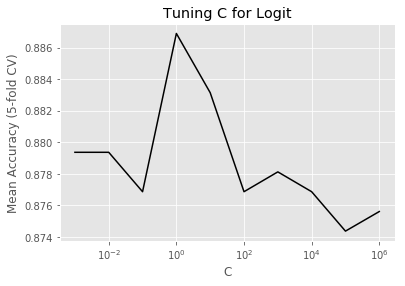

In [34]:
# Plotting Accuracy Score by C
plt.rcParams["figure.figsize"] = (6,4)
plt.semilogx(values_logit_chn_pos, scores_logit_chn_pos, 'k-')
plt.title('Tuning C for Logit')
plt.xlabel('C')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [35]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
logit = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_chn_pos["C"][0])
logitfpr_chn_pos, logittpr_chn_pos, logitrocauc_chn_pos, logitprec_chn_pos, logitrec_chn_pos, logitprauc_chn_pos = gk.class_onestep_auc(X_train_chn_pos, y_train_chn_pos, X_test_chn_pos, y_test_chn_pos, logit)
time_logit_chn_pos = trec() - start
print('Computation time is %0.3f seconds' % time_logit_chn_pos)


Computation time is 0.508 seconds


#### 2.1.7 South Korea Data (Positive)

Tuning:

In [36]:
#########################################################
## 2.1.7 Tune Logit Parameters (South Korea, Positive) ##
#########################################################

## Logistic Regression
logit = skl_lm.LogisticRegression(solver='newton-cg')

## Tune C
start = trec()
params = {'C':[0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
optparam_logit_sko_pos, optscore_logit_sko_pos, values_logit_sko_pos, scores_logit_sko_pos = gk.class_optparam(X_train_sko_pos, y_train_sko_pos, logit, params = params)
time_logit_sko_pos_tune = trec() - start
print('Computation time is %0.3f seconds' % time_logit_sko_pos_tune)


Computation time is 16.568 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [37]:
## Print Optimal Parameter Values
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_logit_sko_pos:
    print i, optparam_logit_sko_pos[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_logit_sko_pos)


From 5-Fold Cross Validation, the best parameter values are: 

C [1.0]

The corresponding accuracy score is 0.90934


The accuracy scores for the considered set of paremeter values can be plotted as follows:

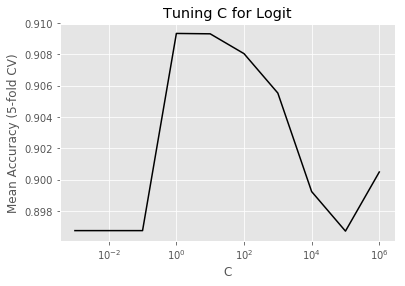

In [38]:
# Plotting Accuracy Score by C
plt.rcParams["figure.figsize"] = (6,4)
plt.semilogx(values_logit_sko_pos, scores_logit_sko_pos, 'k-')
#plt.plot(values_logit, scores_logit, 'k-')
plt.title('Tuning C for Logit')
plt.xlabel('C')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [39]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
logit = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_sko_pos["C"][0])
logitfpr_sko_pos, logittpr_sko_pos, logitrocauc_sko_pos, logitprec_sko_pos, logitrec_sko_pos, logitprauc_sko_pos = gk.class_onestep_auc(X_train_sko_pos, y_train_sko_pos, X_test_sko_pos, y_test_sko_pos, logit)
time_logit_sko_pos = trec() - start
print('Computation time is %0.3f seconds' % time_logit_sko_pos)


Computation time is 0.355 seconds


#### 2.1.8 North Korea Data (Positive)

Tuning:

In [40]:
#########################################################
## 2.1.8 Tune Logit Parameters (North Korea, Positive) ##
#########################################################

## Logistic Regression
logit = skl_lm.LogisticRegression(solver='newton-cg')

## Tune C
start = trec()
params = {'C':[0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
optparam_logit_nko_pos, optscore_logit_nko_pos, values_logit_nko_pos, scores_logit_nko_pos = gk.class_optparam(X_train_nko_pos, y_train_nko_pos, logit, params = params)
time_logit_nko_pos_tune = trec() - start
print('Computation time is %0.3f seconds' % time_logit_nko_pos_tune)


Computation time is 18.036 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [41]:
## Print Optimal Parameter Values
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_logit_nko_pos:
    print i, optparam_logit_nko_pos[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_logit_nko_pos)


From 5-Fold Cross Validation, the best parameter values are: 

C [1.0]

The corresponding accuracy score is 0.83398


The accuracy scores for the considered set of paremeter values can be plotted as follows:

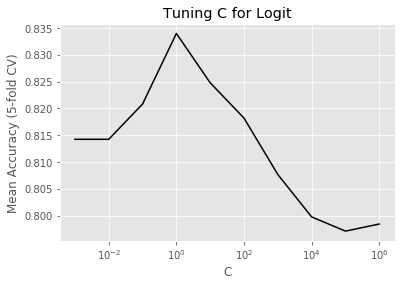

In [42]:
# Plotting Accuracy Score by C
plt.rcParams["figure.figsize"] = (6,4)
plt.semilogx(values_logit_nko_pos, scores_logit_nko_pos, 'k-')
plt.title('Tuning C for Logit')
plt.xlabel('C')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [43]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
logit = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_nko_pos["C"][0])
logitfpr_nko_pos, logittpr_nko_pos, logitrocauc_nko_pos, logitprec_nko_pos, logitrec_nko_pos, logitprauc_nko_pos = gk.class_onestep_auc(X_train_nko_pos, y_train_nko_pos, X_test_nko_pos, y_test_nko_pos, logit)
time_logit_nko_pos = trec() - start
print('Computation time is %0.3f seconds' % time_logit_nko_pos)


Computation time is 0.495 seconds


### 2.2 Random Forest 

In <code>scikit-learn</code> implementation of Random Forest classification, there are two major parameters to optimize. The first parameter is $n\_estimators$, which is the number of trees to grow in each estimation. The second paramter is $max\_features$, which is the maximum number of features (words/variables) to consider in each splitting decision, represented by the proportion or function of number of features. We consider following parameter values in tuning:
 * $n\_estimators \in \{50,100,300, 500\}$
 * $max\_features \in \{\mbox{log},\mbox{square root}\}$


#### 2.2.1 US Data (Negative)

Tuning:

In [44]:
########################################################
## 2.2.1 Tune Random Forest Parameters (US, Negative) ##
########################################################

## Random Forest
rf = RandomForestClassifier(random_state = 7899993, n_jobs=2, oob_score = True)

## Tune # of trees to grow and number of features to consider
start = trec()
params = {'n_estimators': [500,300,100,50],'max_features': ["sqrt","log2"]} # 0.001,0.01,0.05,0.1,0.2,0.5,1. #
optparam_rf_us_neg, optscore_rf_us_neg, values1_rf_us_neg, values2_rf_us_neg, scores_rf_us_neg = gk.class_optparam(X_train_us_neg, y_train_us_neg, rf, params = params, val_method = 'OOB')
time_rf_us_neg_tune = trec() - start
print('Computation time is %0.3f seconds' % time_rf_us_neg_tune)


Computation time is 27.311 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [45]:
## Print Optimal Parameter Values
print 'From OOB Cross Validation, the best parameter values are: \n' 
for i in optparam_rf_us_neg:
    print i, optparam_rf_us_neg[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_rf_us_neg)


From OOB Cross Validation, the best parameter values are: 

n_estimators [300]
max_features ['log2']

The corresponding accuracy score is 0.76299


The accuracy scores for the considered set of paremeter values can be plotted as follows. Cells with brighter colors imply better classification performances:

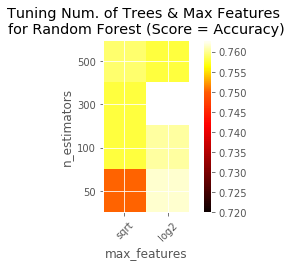

In [46]:
## Plot Validation Result
plt.figure(figsize=(5, 3))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_rf_us_neg, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.72, midpoint=0.75))
plt.xlabel('max_features'); plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(values2_rf_us_neg)), values2_rf_us_neg, rotation=45)
plt.yticks(np.arange(len(values1_rf_us_neg)), values1_rf_us_neg)
plt.title('Tuning Num. of Trees & Max Features \nfor Random Forest (Score = Accuracy)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [47]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
rf = RandomForestClassifier(n_estimators=optparam_rf_us_neg['n_estimators'][0], max_features = optparam_rf_us_neg['max_features'][0], random_state = 7899993, n_jobs=2)
rffpr_us_neg, rftpr_us_neg, rfrocauc_us_neg, rfprec_us_neg, rfrec_us_neg, rfprauc_us_neg = gk.class_onestep_auc(X_train_us_neg, y_train_us_neg, X_test_us_neg, y_test_us_neg, rf)
time_rf_us_neg = trec() - start
print('Computation time is %0.3f seconds' % time_rf_us_neg)


Computation time is 2.488 seconds


#### 2.2.2 China Data (Negative)

Tuning:

In [48]:
###########################################################
## 2.2.2 Tune Random Forest Parameters (China, Negative) ##
###########################################################

## Random Forest
rf = RandomForestClassifier(random_state = 7899993, n_jobs=2, oob_score = True)

## Tune # of trees to grow and number of features to consider
start = trec()
params = {'n_estimators': [500,300,100,50],'max_features': ["sqrt","log2"]} # 0.001,0.01,0.05,0.1,0.2,0.5,1. #
optparam_rf_chn_neg, optscore_rf_chn_neg, values1_rf_chn_neg, values2_rf_chn_neg, scores_rf_chn_neg = gk.class_optparam(X_train_chn_neg, y_train_chn_neg, rf, params = params, val_method = 'OOB')
time_rf_chn_neg_tune = trec() - start
print('Computation time is %0.3f seconds' % time_rf_chn_neg_tune)


Computation time is 19.019 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [49]:
## Print Optimal Parameter Values
print 'From OOB Cross Validation, the best parameter values are: \n' 
for i in optparam_rf_chn_neg:
    print i, optparam_rf_chn_neg[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_rf_chn_neg)


From OOB Cross Validation, the best parameter values are: 

n_estimators [500]
max_features ['sqrt']

The corresponding accuracy score is 0.81156


The accuracy scores for the considered set of paremeter values can be plotted as follows. Cells with brighter colors imply better classification performances:

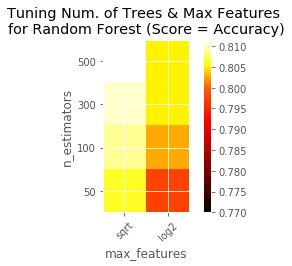

In [50]:
## Plot Validation Result
plt.figure(figsize=(5, 3))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_rf_chn_neg, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.77, midpoint=0.80))
plt.xlabel('max_features'); plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(values2_rf_chn_neg)), values2_rf_chn_neg, rotation=45)
plt.yticks(np.arange(len(values1_rf_chn_neg)), values1_rf_chn_neg)
plt.title('Tuning Num. of Trees & Max Features \nfor Random Forest (Score = Accuracy)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [51]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
rf = RandomForestClassifier(n_estimators=optparam_rf_chn_neg['n_estimators'][0], max_features = optparam_rf_chn_neg['max_features'][0], random_state = 7899993, n_jobs=2)
rffpr_chn_neg, rftpr_chn_neg, rfrocauc_chn_neg, rfprec_chn_neg, rfrec_chn_neg, rfprauc_chn_neg = gk.class_onestep_auc(X_train_chn_neg, y_train_chn_neg, X_test_chn_neg, y_test_chn_neg, rf)
time_rf_chn_neg = trec() - start
print('Computation time is %0.3f seconds' % time_rf_chn_neg)


Computation time is 4.863 seconds


#### 2.2.3 South Korea Data (Negative)

Tuning:

In [52]:
#################################################################
## 2.2.3 Tune Random Forest Parameters (South Korea, Negative) ##
#################################################################

## Random Forest
rf = RandomForestClassifier(random_state = 7899993, n_jobs=2, oob_score = True)

## Tune # of trees to grow and number of features to consider
start = trec()
params = {'n_estimators': [500,300,100,50],'max_features': ["sqrt","log2"]} # 0.001,0.01,0.05,0.1,0.2,0.5,1. #
optparam_rf_sko_neg, optscore_rf_sko_neg, values1_rf_sko_neg, values2_rf_sko_neg, scores_rf_sko_neg = gk.class_optparam(X_train_sko_neg, y_train_sko_neg, rf, params = params, val_method = 'OOB')
time_rf_sko_neg_tune = trec() - start
print('Computation time is %0.3f seconds' % time_rf_sko_neg_tune)


Computation time is 15.197 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [53]:
## Print Optimal Parameter Values
print 'From OOB Cross Validation, the best parameter values are: \n' 
for i in optparam_rf_sko_neg:
    print i, optparam_rf_sko_neg[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_rf_sko_neg)


From OOB Cross Validation, the best parameter values are: 

n_estimators [100, 50]
max_features ['sqrt', 'sqrt']

The corresponding accuracy score is 0.91688


The accuracy scores for the considered set of paremeter values can be plotted as follows. Cells with brighter colors imply better classification performances:

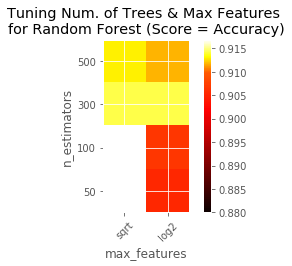

In [54]:
## Plot Validation Result
plt.figure(figsize=(5, 3))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_rf_sko_neg, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.88, midpoint=0.91))
plt.xlabel('max_features'); plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(values2_rf_sko_neg)), values2_rf_sko_neg, rotation=45)
plt.yticks(np.arange(len(values1_rf_sko_neg)), values1_rf_sko_neg)
plt.title('Tuning Num. of Trees & Max Features \nfor Random Forest (Score = Accuracy)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [55]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
rf = RandomForestClassifier(n_estimators=optparam_rf_sko_neg['n_estimators'][0], max_features = optparam_rf_sko_neg['max_features'][0], random_state = 7899993, n_jobs=2)
rffpr_sko_neg, rftpr_sko_neg, rfrocauc_sko_neg, rfprec_sko_neg, rfrec_sko_neg, rfprauc_sko_neg = gk.class_onestep_auc(X_train_sko_neg, y_train_sko_neg, X_test_sko_neg, y_test_sko_neg, rf)
time_rf_sko_neg = trec() - start
print('Computation time is %0.3f seconds' % time_rf_sko_neg)


Computation time is 1.065 seconds


#### 2.2.4 North Korea Data (Negative)

Tuning:

In [56]:
#################################################################
## 2.2.4 Tune Random Forest Parameters (North Korea, Negative) ##
#################################################################

## Random Forest
rf = RandomForestClassifier(random_state = 7899993, n_jobs=2, oob_score = True)

## Tune # of trees to grow and number of features to consider
start = trec()
params = {'n_estimators': [500,300,100,50],'max_features': ["sqrt","log2"]} # 0.001,0.01,0.05,0.1,0.2,0.5,1. #
optparam_rf_nko_neg, optscore_rf_nko_neg, values1_rf_nko_neg, values2_rf_nko_neg, scores_rf_nko_neg = gk.class_optparam(X_train_nko_neg, y_train_nko_neg, rf, params = params, val_method = 'OOB')
time_rf_nko_neg_tune = trec() - start
print('Computation time is %0.3f seconds' % time_rf_nko_neg_tune)


Computation time is 14.617 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [57]:
## Print Optimal Parameter Values
print 'From OOB Cross Validation, the best parameter values are: \n' 
for i in optparam_rf_nko_neg:
    print i, optparam_rf_nko_neg[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_rf_nko_neg)


From OOB Cross Validation, the best parameter values are: 

n_estimators [500]
max_features ['log2']

The corresponding accuracy score is 0.72727


The accuracy scores for the considered set of paremeter values can be plotted as follows. Cells with brighter colors imply better classification performances:

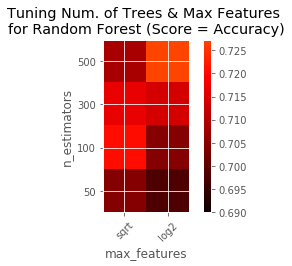

In [58]:
## Plot Validation Result
plt.figure(figsize=(5, 3))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_rf_nko_neg, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.69, midpoint=0.73))
plt.xlabel('max_features'); plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(values2_rf_nko_neg)), values2_rf_nko_neg, rotation=45)
plt.yticks(np.arange(len(values1_rf_nko_neg)), values1_rf_nko_neg)
plt.title('Tuning Num. of Trees & Max Features \nfor Random Forest (Score = Accuracy)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [59]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
rf = RandomForestClassifier(n_estimators=optparam_rf_nko_neg['n_estimators'][0], max_features = optparam_rf_nko_neg['max_features'][0], random_state = 7899993, n_jobs=2)
rffpr_nko_neg, rftpr_nko_neg, rfrocauc_nko_neg, rfprec_nko_neg, rfrec_nko_neg, rfprauc_nko_neg = gk.class_onestep_auc(X_train_nko_neg, y_train_nko_neg, X_test_nko_neg, y_test_nko_neg, rf)
time_rf_nko_neg = trec() - start
print('Computation time is %0.3f seconds' % time_rf_nko_neg)


Computation time is 3.467 seconds


#### 2.2.5 US Data (Positive)

Tuning:

In [60]:
########################################################
## 2.2.5 Tune Random Forest Parameters (US, Positive) ##
########################################################

## Random Forest
rf = RandomForestClassifier(random_state = 7899993, n_jobs=2, oob_score = True)

## Tune # of trees to grow and number of features to consider
start = trec()
params = {'n_estimators': [500,300,100,50],'max_features': ["sqrt","log2"]} # 0.001,0.01,0.05,0.1,0.2,0.5,1. #
optparam_rf_us_pos, optscore_rf_us_pos, values1_rf_us_pos, values2_rf_us_pos, scores_rf_us_pos = gk.class_optparam(X_train_us_pos, y_train_us_pos, rf, params = params, val_method = 'OOB')
time_rf_us_pos_tune = trec() - start
print('Computation time is %0.3f seconds' % time_rf_us_pos_tune)


Computation time is 24.934 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [61]:
## Print Optimal Parameter Values
print 'From OOB Cross Validation, the best parameter values are: \n' 
for i in optparam_rf_us_pos:
    print i, optparam_rf_us_pos[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_rf_us_pos)


From OOB Cross Validation, the best parameter values are: 

n_estimators [500, 300, 100, 50]
max_features ['log2', 'log2', 'log2', 'sqrt']

The corresponding accuracy score is 0.87199


The accuracy scores for the considered set of paremeter values can be plotted as follows. Cells with brighter colors imply better classification performances:

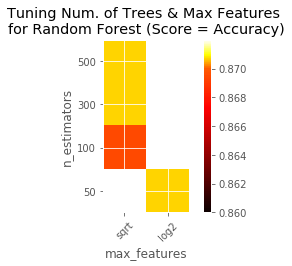

In [62]:
## Plot Validation Result
plt.figure(figsize=(5, 3))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_rf_us_pos, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.86, midpoint=0.87))
plt.xlabel('max_features'); plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(values2_rf_us_pos)), values2_rf_us_pos, rotation=45)
plt.yticks(np.arange(len(values1_rf_us_pos)), values1_rf_us_pos)
plt.title('Tuning Num. of Trees & Max Features \nfor Random Forest (Score = Accuracy)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [63]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
rf = RandomForestClassifier(n_estimators=optparam_rf_us_pos['n_estimators'][0], max_features = optparam_rf_us_pos['max_features'][0], random_state = 7899993, n_jobs=2)
rffpr_us_pos, rftpr_us_pos, rfrocauc_us_pos, rfprec_us_pos, rfrec_us_pos, rfprauc_us_pos = gk.class_onestep_auc(X_train_us_pos, y_train_us_pos, X_test_us_pos, y_test_us_pos, rf)
time_rf_us_pos = trec() - start
print('Computation time is %0.3f seconds' % time_rf_us_pos)


Computation time is 4.030 seconds


#### 2.2.6 China Data (Positive)

Tuning:

In [64]:
###########################################################
## 2.2.6 Tune Random Forest Parameters (China, Positive) ##
###########################################################

## Random Forest
rf = RandomForestClassifier(random_state = 7899993, n_jobs=2, oob_score = True)

## Tune # of trees to grow and number of features to consider
start = trec()
params = {'n_estimators': [500,300,100,50],'max_features': ["sqrt","log2"]} # 0.001,0.01,0.05,0.1,0.2,0.5,1. #
optparam_rf_chn_pos, optscore_rf_chn_pos, values1_rf_chn_pos, values2_rf_chn_pos, scores_rf_chn_pos = gk.class_optparam(X_train_chn_pos, y_train_chn_pos, rf, params = params, val_method = 'OOB')
time_rf_chn_pos_tune = trec() - start
print('Computation time is %0.3f seconds' % time_rf_chn_pos_tune)


Computation time is 17.799 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [65]:
## Print Optimal Parameter Values
print 'From OOB Cross Validation, the best parameter values are: \n' 
for i in optparam_rf_chn_pos:
    print i, optparam_rf_chn_pos[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_rf_chn_pos)


From OOB Cross Validation, the best parameter values are: 

n_estimators [300]
max_features ['sqrt']

The corresponding accuracy score is 0.89196


The accuracy scores for the considered set of paremeter values can be plotted as follows. Cells with brighter colors imply better classification performances:

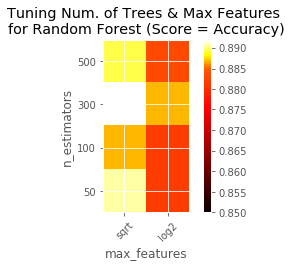

In [66]:
## Plot Validation Result
plt.figure(figsize=(5, 3))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_rf_chn_pos, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.85, midpoint=0.885))
plt.xlabel('max_features'); plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(values2_rf_chn_pos)), values2_rf_chn_pos, rotation=45)
plt.yticks(np.arange(len(values1_rf_chn_pos)), values1_rf_chn_pos)
plt.title('Tuning Num. of Trees & Max Features \nfor Random Forest (Score = Accuracy)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [67]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
rf = RandomForestClassifier(n_estimators=optparam_rf_chn_pos['n_estimators'][0], max_features = optparam_rf_chn_pos['max_features'][0], random_state = 7899993, n_jobs=2)
rffpr_chn_pos, rftpr_chn_pos, rfrocauc_chn_pos, rfprec_chn_pos, rfrec_chn_pos, rfprauc_chn_pos = gk.class_onestep_auc(X_train_chn_pos, y_train_chn_pos, X_test_chn_pos, y_test_chn_pos, rf)
time_rf_chn_pos = trec() - start
print('Computation time is %0.3f seconds' % time_rf_chn_pos)


Computation time is 2.878 seconds


#### 2.2.7 South Korea Data (Positive)

Tuning:

In [68]:
#################################################################
## 2.2.7 Tune Random Forest Parameters (South Korea, Positive) ##
#################################################################

## Random Forest
rf = RandomForestClassifier(random_state = 7899993, n_jobs=2, oob_score = True)

## Tune # of trees to grow and number of features to consider
start = trec()
params = {'n_estimators': [500,300,100,50],'max_features': ["sqrt","log2"]} # 0.001,0.01,0.05,0.1,0.2,0.5,1. #
optparam_rf_sko_pos, optscore_rf_sko_pos, values1_rf_sko_pos, values2_rf_sko_pos, scores_rf_sko_pos = gk.class_optparam(X_train_sko_pos, y_train_sko_pos, rf, params = params, val_method = 'OOB')
time_rf_sko_pos_tune = trec() - start
print('Computation time is %0.3f seconds' % time_rf_sko_pos_tune)


Computation time is 12.789 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [69]:
## Print Optimal Parameter Values
print 'From OOB Cross Validation, the best parameter values are: \n' 
for i in optparam_rf_sko_pos:
    print i, optparam_rf_sko_pos[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_rf_sko_pos)


From OOB Cross Validation, the best parameter values are: 

n_estimators [500, 300, 50]
max_features ['sqrt', 'sqrt', 'sqrt']

The corresponding accuracy score is 0.90050


The accuracy scores for the considered set of paremeter values can be plotted as follows. Cells with brighter colors imply better classification performances:

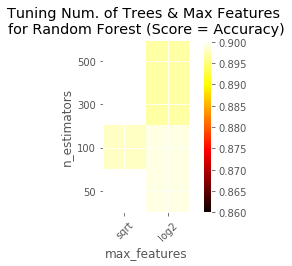

In [70]:
## Plot Validation Result
plt.figure(figsize=(5, 3))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_rf_sko_pos, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.86, midpoint=0.88))
plt.xlabel('max_features'); plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(values2_rf_sko_pos)), values2_rf_sko_pos, rotation=45)
plt.yticks(np.arange(len(values1_rf_sko_pos)), values1_rf_sko_pos)
plt.title('Tuning Num. of Trees & Max Features \nfor Random Forest (Score = Accuracy)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [71]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
rf = RandomForestClassifier(n_estimators=optparam_rf_sko_pos['n_estimators'][0], max_features = optparam_rf_sko_pos['max_features'][0], random_state = 7899993, n_jobs=2)
rffpr_sko_pos, rftpr_sko_pos, rfrocauc_sko_pos, rfprec_sko_pos, rfrec_sko_pos, rfprauc_sko_pos = gk.class_onestep_auc(X_train_sko_pos, y_train_sko_pos, X_test_sko_pos, y_test_sko_pos, rf)
time_rf_sko_pos = trec() - start
print('Computation time is %0.3f seconds' % time_rf_sko_pos)


Computation time is 3.485 seconds


#### 2.3.8 North Korea Data (Positive)

Tuning:

In [72]:
#################################################################
## 2.2.8 Tune Random Forest Parameters (North Korea, Positive) ##
#################################################################

## Random Forest
rf = RandomForestClassifier(random_state = 7899993, n_jobs=2, oob_score = True)

## Tune # of trees to grow and number of features to consider
start = trec()
params = {'n_estimators': [500,300,100,50],'max_features': ["sqrt","log2"]} # 0.001,0.01,0.05,0.1,0.2,0.5,1. #
optparam_rf_nko_pos, optscore_rf_nko_pos, values1_rf_nko_pos, values2_rf_nko_pos, scores_rf_nko_pos = gk.class_optparam(X_train_nko_pos, y_train_nko_pos, rf, params = params, val_method = 'OOB')
time_rf_nko_pos_tune = trec() - start
print('Computation time is %0.3f seconds' % time_rf_nko_pos_tune)


Computation time is 14.161 seconds


From the tuning, the optimal parameter values are estimated as follows:

In [73]:
## Print Optimal Parameter Values
print 'From OOB Cross Validation, the best parameter values are: \n' 
for i in optparam_rf_nko_pos:
    print i, optparam_rf_nko_pos[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_rf_nko_pos)


From OOB Cross Validation, the best parameter values are: 

n_estimators [500, 300, 50, 50]
max_features ['log2', 'log2', 'sqrt', 'log2']

The corresponding accuracy score is 0.81818


The accuracy scores for the considered set of paremeter values can be plotted as follows. Cells with brighter colors imply better classification performances:

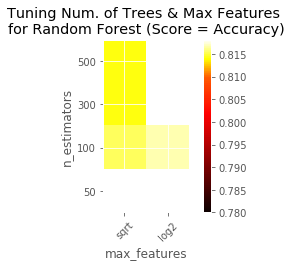

In [74]:
## Plot Validation Result
plt.figure(figsize=(5, 3))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_rf_nko_pos, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.78, midpoint=0.81))
plt.xlabel('max_features'); plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(values2_rf_nko_pos)), values2_rf_nko_pos, rotation=45)
plt.yticks(np.arange(len(values1_rf_nko_pos)), values1_rf_nko_pos)
plt.title('Tuning Num. of Trees & Max Features \nfor Random Forest (Score = Accuracy)')
plt.show()


Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set:

In [75]:
## Predict Test Set Coding Using Classfier with Optimized Parameter Values Trained on Training Set
start = trec()
rf = RandomForestClassifier(n_estimators=optparam_rf_nko_pos['n_estimators'][0], max_features = optparam_rf_nko_pos['max_features'][0], random_state = 7899993, n_jobs=2)
rffpr_nko_pos, rftpr_nko_pos, rfrocauc_nko_pos, rfprec_nko_pos, rfrec_nko_pos, rfprauc_nko_pos = gk.class_onestep_auc(X_train_nko_pos, y_train_nko_pos, X_test_nko_pos, y_test_nko_pos, rf)
time_rf_nko_pos = trec() - start
print('Computation time is %0.3f seconds' % time_rf_nko_pos)


Computation time is 2.914 seconds


### 2.3 Temporarily Save Predictions

##### All analytical results (except for lda function) are saved by following codes:

In [76]:
######################################
## 2.3 Temporarily Save Predictions ##
######################################

start = trec()

## List of Object to Save
objectlist = ['logitfpr_us_neg', 'logittpr_us_neg', 'logitrocauc_us_neg', 'logitprec_us_neg', 'logitrec_us_neg', 'logitprauc_us_neg',
              'optparam_logit_us_neg','optscore_logit_us_neg', 'scores_logit_us_neg', 'values_logit_us_neg', 'time_logit_us_neg_tune', 'time_logit_us_neg', 
              'logitfpr_chn_neg', 'logittpr_chn_neg', 'logitrocauc_chn_neg', 'logitprec_chn_neg', 'logitrec_chn_neg', 'logitprauc_chn_neg',
              'optparam_logit_chn_neg','optscore_logit_chn_neg', 'scores_logit_chn_neg', 'values_logit_chn_neg', 'time_logit_chn_neg_tune', 'time_logit_chn_neg', 
              'logitfpr_sko_neg', 'logittpr_sko_neg', 'logitrocauc_sko_neg', 'logitprec_sko_neg', 'logitrec_sko_neg', 'logitprauc_sko_neg',
              'optparam_logit_sko_neg','optscore_logit_sko_neg', 'scores_logit_sko_neg', 'values_logit_sko_neg', 'time_logit_sko_neg_tune', 'time_logit_sko_neg', 
              'logitfpr_nko_neg', 'logittpr_nko_neg', 'logitrocauc_nko_neg', 'logitprec_nko_neg', 'logitrec_nko_neg', 'logitprauc_nko_neg',
              'optparam_logit_nko_neg','optscore_logit_nko_neg', 'scores_logit_nko_neg', 'values_logit_nko_neg', 'time_logit_nko_neg_tune', 'time_logit_nko_neg', 
              'rffpr_us_neg', 'rftpr_us_neg', 'rfrocauc_us_neg', 'rfprec_us_neg', 'rfrec_us_neg', 'rfprauc_us_neg',
              'rffpr_chn_neg', 'rftpr_chn_neg', 'rfrocauc_chn_neg', 'rfprec_chn_neg', 'rfrec_chn_neg', 'rfprauc_chn_neg',
              'optparam_rf_chn_neg','optscore_rf_chn_neg','values1_rf_chn_neg','values2_rf_chn_neg','scores_rf_chn_neg','time_rf_chn_neg_tune','time_rf_chn_neg',
              'optparam_rf_us_neg','optscore_rf_us_neg','values1_rf_us_neg','values2_rf_us_neg','scores_rf_us_neg','time_rf_us_neg_tune','time_rf_us_neg',
              'rffpr_sko_neg', 'rftpr_sko_neg', 'rfrocauc_sko_neg', 'rfprec_sko_neg', 'rfrec_sko_neg', 'rfprauc_sko_neg',
              'optparam_rf_sko_neg','optscore_rf_sko_neg','values1_rf_sko_neg','values2_rf_sko_neg','scores_rf_sko_neg','time_rf_sko_neg_tune','time_rf_sko_neg',
              'rffpr_nko_neg', 'rftpr_nko_neg', 'rfrocauc_nko_neg', 'rfprec_nko_neg', 'rfrec_nko_neg', 'rfprauc_nko_neg',
              'optparam_rf_nko_neg','optscore_rf_nko_neg','values1_rf_nko_neg','values2_rf_nko_neg','scores_rf_nko_neg','time_rf_nko_neg_tune','time_rf_nko_neg',
              'logitfpr_us_pos', 'logittpr_us_pos', 'logitrocauc_us_pos', 'logitprec_us_pos', 'logitrec_us_pos', 'logitprauc_us_pos',
              'optparam_logit_us_pos','optscore_logit_us_pos', 'scores_logit_us_pos', 'values_logit_us_pos', 'time_logit_us_pos_tune', 'time_logit_us_pos', 
              'logitfpr_chn_pos', 'logittpr_chn_pos', 'logitrocauc_chn_pos', 'logitprec_chn_pos', 'logitrec_chn_pos', 'logitprauc_chn_pos',
              'optparam_logit_chn_pos','optscore_logit_chn_pos', 'scores_logit_chn_pos', 'values_logit_chn_pos', 'time_logit_chn_pos_tune', 'time_logit_chn_pos', 
              'logitfpr_sko_pos', 'logittpr_sko_pos', 'logitrocauc_sko_pos', 'logitprec_sko_pos', 'logitrec_sko_pos', 'logitprauc_sko_pos',
              'optparam_logit_sko_pos','optscore_logit_sko_pos', 'scores_logit_sko_pos', 'values_logit_sko_pos', 'time_logit_sko_pos_tune', 'time_logit_sko_pos', 
              'logitfpr_nko_pos', 'logittpr_nko_pos', 'logitrocauc_nko_pos', 'logitprec_nko_pos', 'logitrec_nko_pos', 'logitprauc_nko_pos',
              'optparam_logit_nko_pos','optscore_logit_nko_pos', 'scores_logit_nko_pos', 'values_logit_nko_pos', 'time_logit_nko_pos_tune', 'time_logit_nko_pos', 
              'rffpr_us_pos', 'rftpr_us_pos', 'rfrocauc_us_pos', 'rfprec_us_pos', 'rfrec_us_pos', 'rfprauc_us_pos',
              'rffpr_chn_pos', 'rftpr_chn_pos', 'rfrocauc_chn_pos', 'rfprec_chn_pos', 'rfrec_chn_pos', 'rfprauc_chn_pos',
              'optparam_rf_chn_pos','optscore_rf_chn_pos','values1_rf_chn_pos','values2_rf_chn_pos','scores_rf_chn_pos','time_rf_chn_pos_tune','time_rf_chn_pos',
              'optparam_rf_us_pos','optscore_rf_us_pos','values1_rf_us_pos','values2_rf_us_pos','scores_rf_us_pos','time_rf_us_pos_tune','time_rf_us_pos',
              'rffpr_sko_pos', 'rftpr_sko_pos', 'rfrocauc_sko_pos', 'rfprec_sko_pos', 'rfrec_sko_pos', 'rfprauc_sko_pos',
              'optparam_rf_sko_pos','optscore_rf_sko_pos','values1_rf_sko_pos','values2_rf_sko_pos','scores_rf_sko_pos','time_rf_sko_pos_tune','time_rf_sko_pos',
              'rffpr_nko_pos', 'rftpr_nko_pos', 'rfrocauc_nko_pos', 'rfprec_nko_pos', 'rfrec_nko_pos', 'rfprauc_nko_pos',
              'optparam_rf_nko_pos','optscore_rf_nko_pos','values1_rf_nko_pos','values2_rf_nko_pos','scores_rf_nko_pos','time_rf_nko_pos_tune','time_rf_nko_pos',
              'logit',"rf"]

## Save Objects
filename='../data_heavy/machine_coding.db'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in objectlist:
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        # __builtins__, my_shelf, and imported modules can not be shelved.
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

time = trec() - start
print('Computation time is %0.3f seconds' % time)


Computation time is 3.334 seconds


##### All analytical results can be restored by following codes: 

In [77]:
# ## Restore Saved Objects

# start = trec()

# ## Restore the Previous Session with Analytical Results
# filename='../data_heavy/machine_coding.db'
# my_shelf = shelve.open(filename)
# for key in my_shelf:
#     globals()[key]=my_shelf[key]
# my_shelf.close()

# time = trec() - start
# print('Computation time is %0.3f seconds' % time)


## 3. Assess Classification Outcomes on Test Set

In this subsection, we assess the performence of classification methods on test-set, using paremeter values tuned in the previous subsection. In particular, we use ROC curve and Precision-Recall (PR) curve to evaluate performances. The assessment suggests that logistic regression and random forest are both computationally efficient and well performing methods.

### 3.1 ROC Curve

The following eight plots show ROC curves from the test-set predictions of supervised-learning methods with tuned parameter values.  

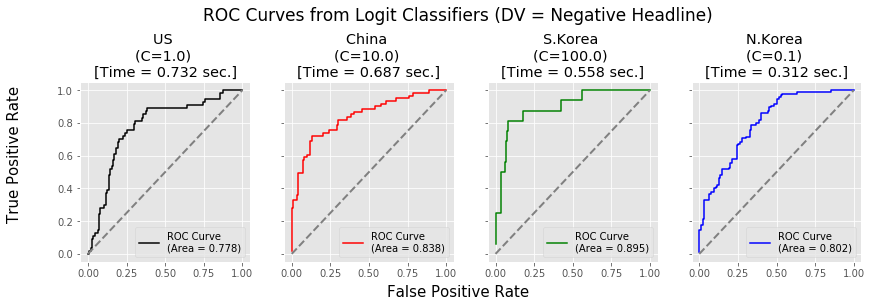

In [126]:
#####################################
## 3.1 ROC Curve (Logit, Negative) ##
#####################################

plt.rcParams["figure.figsize"] = (14,4)
f, (ax1, ax2, ax3, ax4),  = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.75)
f.text(0.5, 0.98, 'ROC Curves from Logit Classifiers (DV = Negative Headline)', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'False Positive Rate', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'True Positive Rate', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(logitfpr_us_neg, logittpr_us_neg, 'k-', label = 'ROC Curve \n(Area = %0.3f)' % logitrocauc_us_neg)
ax1.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax1.set_title('US \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_us_neg["C"][0], time_logit_us_neg));
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(logitfpr_chn_neg, logittpr_chn_neg, 'r-', label = 'ROC Curve \n(Area = %0.3f)' % logitrocauc_chn_neg)
ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax2.set_title('China \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_chn_neg["C"][0], time_logit_chn_neg));
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(logitfpr_sko_neg, logittpr_sko_neg, 'g-', label = 'ROC Curve \n(Area = %0.3f)' % logitrocauc_sko_neg)
ax3.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax3.set_title('S.Korea \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_sko_neg["C"][0], time_logit_sko_neg));
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(logitfpr_nko_neg, logittpr_nko_neg, 'b-', label = 'ROC Curve \n(Area = %0.3f)' % logitrocauc_nko_neg)
ax4.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax4.set_title('N.Korea \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_nko_neg["C"][0], time_logit_nko_neg));
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")

plt.show()


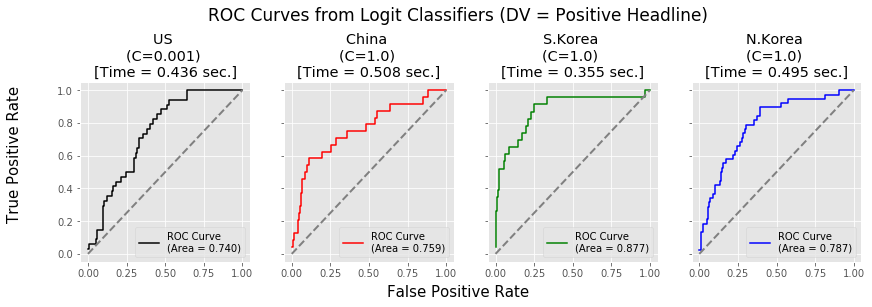

In [127]:
#####################################
## 3.1 ROC Curve (Logit, Positive) ##
#####################################

plt.rcParams["figure.figsize"] = (14,4)
f, (ax1, ax2, ax3, ax4),  = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.75)
f.text(0.5, 0.98, 'ROC Curves from Logit Classifiers (DV = Positive Headline)', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'False Positive Rate', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'True Positive Rate', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(logitfpr_us_pos, logittpr_us_pos, 'k-', label = 'ROC Curve \n(Area = %0.3f)' % logitrocauc_us_pos)
ax1.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax1.set_title('US \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_us_pos["C"][0], time_logit_us_pos));
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(logitfpr_chn_pos, logittpr_chn_pos, 'r-', label = 'ROC Curve \n(Area = %0.3f)' % logitrocauc_chn_pos)
ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax2.set_title('China \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_chn_pos["C"][0], time_logit_chn_pos));
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(logitfpr_sko_pos, logittpr_sko_pos, 'g-', label = 'ROC Curve \n(Area = %0.3f)' % logitrocauc_sko_pos)
ax3.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax3.set_title('S.Korea \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_sko_pos["C"][0], time_logit_sko_pos));
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(logitfpr_nko_pos, logittpr_nko_pos, 'b-', label = 'ROC Curve \n(Area = %0.3f)' % logitrocauc_nko_pos)
ax4.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax4.set_title('N.Korea \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_nko_pos["C"][0], time_logit_nko_pos));
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")

plt.show()


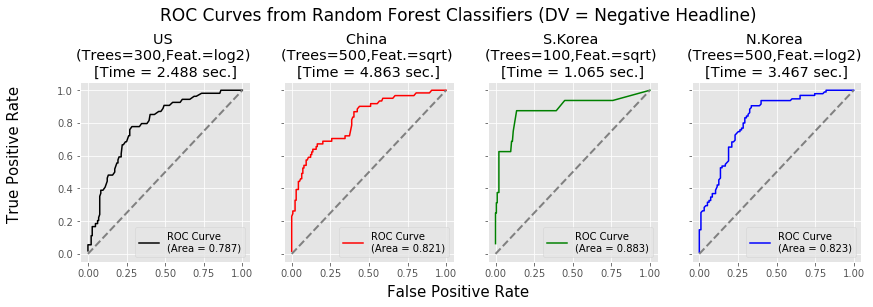

In [128]:
#############################################
## 3.1 ROC Curve (Random Forest, Negative) ##
#############################################

plt.rcParams["figure.figsize"] = (14,4)
f, (ax1, ax2, ax3, ax4),  = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.75)
f.text(0.5, 0.98, 'ROC Curves from Random Forest Classifiers (DV = Negative Headline)', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'False Positive Rate', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'True Positive Rate', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(rffpr_us_neg, rftpr_us_neg, 'k-', label = 'ROC Curve \n(Area = %0.3f)' % rfrocauc_us_neg)
ax1.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax1.set_title('US \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_us_neg['n_estimators'][0], optparam_rf_us_neg['max_features'][0], time_rf_us_neg));
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(rffpr_chn_neg, rftpr_chn_neg, 'r-', label = 'ROC Curve \n(Area = %0.3f)' % rfrocauc_chn_neg)
ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax2.set_title('China \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_chn_neg['n_estimators'][0], optparam_rf_chn_neg['max_features'][0], time_rf_chn_neg));
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(rffpr_sko_neg, rftpr_sko_neg, 'g-', label = 'ROC Curve \n(Area = %0.3f)' % rfrocauc_sko_neg)
ax3.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax3.set_title('S.Korea \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_sko_neg['n_estimators'][0], optparam_rf_sko_neg['max_features'][0], time_rf_sko_neg));
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(rffpr_nko_neg, rftpr_nko_neg, 'b-', label = 'ROC Curve \n(Area = %0.3f)' % rfrocauc_nko_neg)
ax4.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax4.set_title('N.Korea \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_nko_neg['n_estimators'][0], optparam_rf_nko_neg['max_features'][0], time_rf_nko_neg));
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")

plt.show()


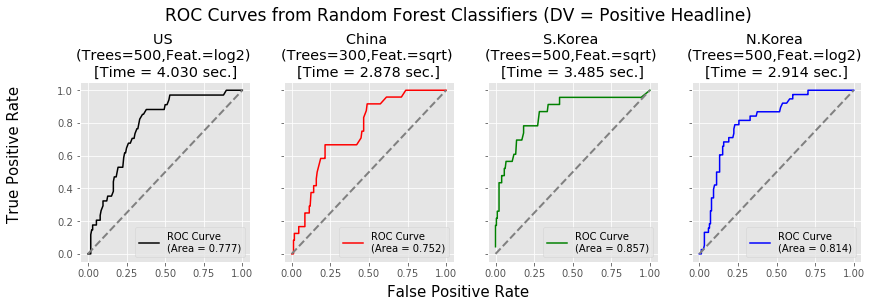

In [129]:
#############################################
## 3.1 ROC Curve (Random Forest, Positive) ##
#############################################

plt.rcParams["figure.figsize"] = (14,4)
f, (ax1, ax2, ax3, ax4),  = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.75)
f.text(0.5, 0.98, 'ROC Curves from Random Forest Classifiers (DV = Positive Headline)', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'False Positive Rate', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'True Positive Rate', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(rffpr_us_pos, rftpr_us_pos, 'k-', label = 'ROC Curve \n(Area = %0.3f)' % rfrocauc_us_pos)
ax1.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax1.set_title('US \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_us_pos['n_estimators'][0], optparam_rf_us_pos['max_features'][0], time_rf_us_pos));
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(rffpr_chn_pos, rftpr_chn_pos, 'r-', label = 'ROC Curve \n(Area = %0.3f)' % rfrocauc_chn_pos)
ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax2.set_title('China \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_chn_pos['n_estimators'][0], optparam_rf_chn_pos['max_features'][0], time_rf_chn_pos));
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(rffpr_sko_pos, rftpr_sko_pos, 'g-', label = 'ROC Curve \n(Area = %0.3f)' % rfrocauc_sko_pos)
ax3.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax3.set_title('S.Korea \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_sko_pos['n_estimators'][0], optparam_rf_sko_pos['max_features'][0], time_rf_sko_pos));
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(rffpr_nko_pos, rftpr_nko_pos, 'b-', label = 'ROC Curve \n(Area = %0.3f)' % rfrocauc_nko_pos)
ax4.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax4.set_title('N.Korea \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_nko_pos['n_estimators'][0], optparam_rf_nko_pos['max_features'][0], time_rf_nko_pos));
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")

plt.show()


### 3.2 Precision-Recall (PR) Curve

The following eight plots show Precision-Recall (PR) curves from the test-set predictions of supervised-learning methods with tuned parameter values.  

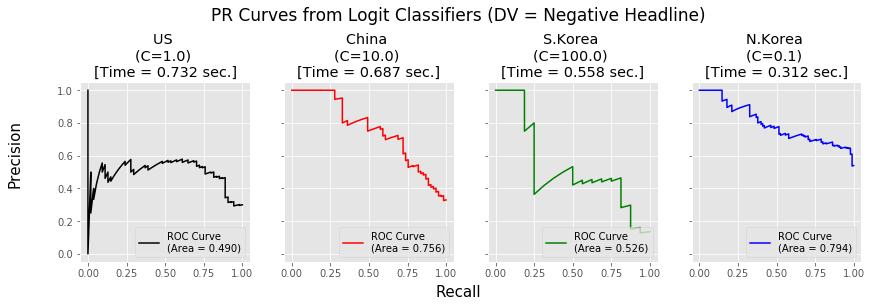

In [130]:
##################################################
## 3.2 Precision-Recall Curve (Logit, Negative) ##
##################################################

plt.rcParams["figure.figsize"] = (14,4)
f, (ax1, ax2, ax3, ax4),  = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.75)
f.text(0.5, 0.98, 'PR Curves from Logit Classifiers (DV = Negative Headline)', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'Recall', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'Precision', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(logitrec_us_neg, logitprec_us_neg, 'k-', label = 'ROC Curve \n(Area = %0.3f)' % logitprauc_us_neg)
ax1.set_title('US \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_us_neg["C"][0], time_logit_us_neg));
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(logitrec_chn_neg, logitprec_chn_neg, 'r-', label = 'ROC Curve \n(Area = %0.3f)' % logitprauc_chn_neg)
ax2.set_title('China \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_chn_neg["C"][0], time_logit_chn_neg));
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(logitrec_sko_neg, logitprec_sko_neg, 'g-', label = 'ROC Curve \n(Area = %0.3f)' % logitprauc_sko_neg)
ax3.set_title('S.Korea \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_sko_neg["C"][0], time_logit_sko_neg));
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(logitrec_nko_neg, logitprec_nko_neg, 'b-', label = 'ROC Curve \n(Area = %0.3f)' % logitprauc_nko_neg)
ax4.set_title('N.Korea \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_nko_neg["C"][0], time_logit_nko_neg));
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")

plt.show()


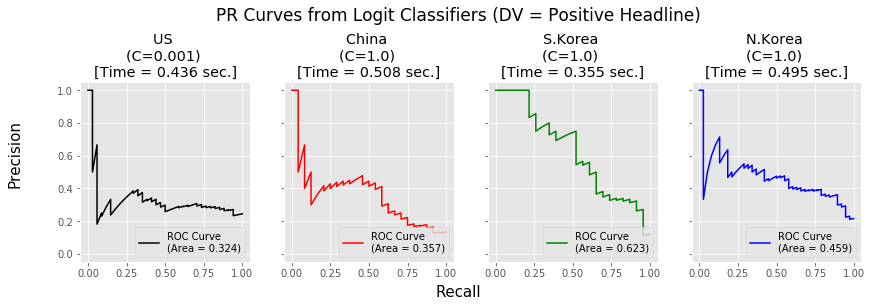

In [131]:
##################################################
## 3.2 Precision-Recall Curve (Logit, Positive) ##
##################################################

plt.rcParams["figure.figsize"] = (14,4)
f, (ax1, ax2, ax3, ax4),  = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.75)
f.text(0.5, 0.98, 'PR Curves from Logit Classifiers (DV = Positive Headline)', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'Recall', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'Precision', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(logitrec_us_pos, logitprec_us_pos, 'k-', label = 'ROC Curve \n(Area = %0.3f)' % logitprauc_us_pos)
ax1.set_title('US \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_us_pos["C"][0], time_logit_us_pos));
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(logitrec_chn_pos, logitprec_chn_pos, 'r-', label = 'ROC Curve \n(Area = %0.3f)' % logitprauc_chn_pos)
ax2.set_title('China \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_chn_pos["C"][0], time_logit_chn_pos));
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(logitrec_sko_pos, logitprec_sko_pos, 'g-', label = 'ROC Curve \n(Area = %0.3f)' % logitprauc_sko_pos)
ax3.set_title('S.Korea \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_sko_pos["C"][0], time_logit_sko_pos));
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(logitrec_nko_pos, logitprec_nko_pos, 'b-', label = 'ROC Curve \n(Area = %0.3f)' % logitprauc_nko_pos)
ax4.set_title('N.Korea \n(C=%r) \n[Time = %0.3f sec.]' % (optparam_logit_nko_pos["C"][0], time_logit_nko_pos));
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")

plt.show()


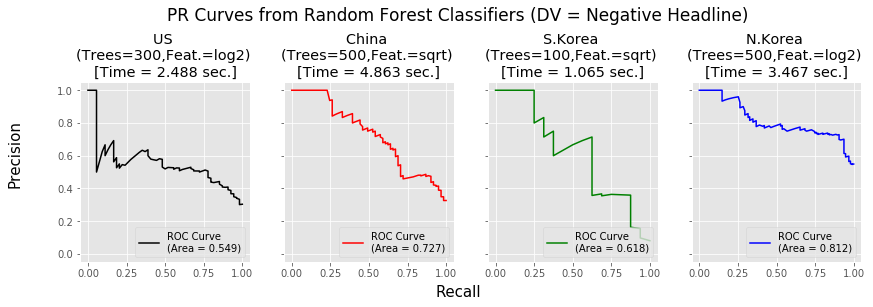

In [132]:
##########################################################
## 3.2 Precision-Recall Curve (Random Forest, Negative) ##
##########################################################

plt.rcParams["figure.figsize"] = (14,4)
f, (ax1, ax2, ax3, ax4),  = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.75)
f.text(0.5, 0.98, 'PR Curves from Random Forest Classifiers (DV = Negative Headline)', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'Recall', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'Precision', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(rfrec_us_neg, rfprec_us_neg, 'k-', label = 'ROC Curve \n(Area = %0.3f)' % rfprauc_us_neg)
ax1.set_title('US \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_us_neg['n_estimators'][0], optparam_rf_us_neg['max_features'][0], time_rf_us_neg));
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(rfrec_chn_neg, rfprec_chn_neg, 'r-', label = 'ROC Curve \n(Area = %0.3f)' % rfprauc_chn_neg)
ax2.set_title('China \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_chn_neg['n_estimators'][0], optparam_rf_chn_neg['max_features'][0], time_rf_chn_neg));
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(rfrec_sko_neg, rfprec_sko_neg, 'g-', label = 'ROC Curve \n(Area = %0.3f)' % rfprauc_sko_neg)
ax3.set_title('S.Korea \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_sko_neg['n_estimators'][0], optparam_rf_sko_neg['max_features'][0], time_rf_sko_neg));
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(rfrec_nko_neg, rfprec_nko_neg, 'b-', label = 'ROC Curve \n(Area = %0.3f)' % rfprauc_nko_neg)
ax4.set_title('N.Korea \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_nko_neg['n_estimators'][0], optparam_rf_nko_neg['max_features'][0], time_rf_nko_neg));
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")

plt.show()


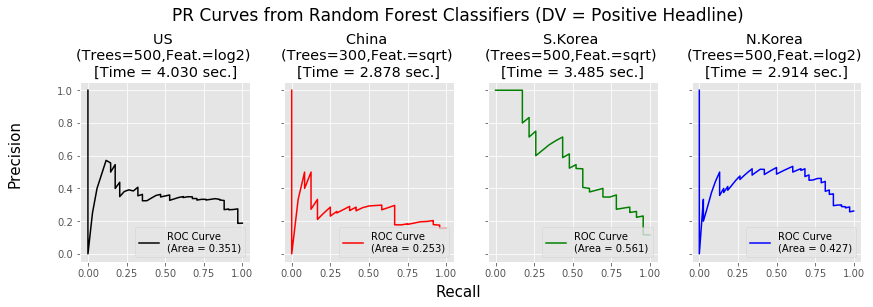

In [133]:
##########################################################
## 3.2 Precision-Recall Curve (Random Forest, Positive) ##
##########################################################

plt.rcParams["figure.figsize"] = (14,4)
f, (ax1, ax2, ax3, ax4),  = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.75)
f.text(0.5, 0.98, 'PR Curves from Random Forest Classifiers (DV = Positive Headline)', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'Recall', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'Precision', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(rfrec_us_pos, rfprec_us_pos, 'k-', label = 'ROC Curve \n(Area = %0.3f)' % rfprauc_us_pos)
ax1.set_title('US \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_us_pos['n_estimators'][0], optparam_rf_us_pos['max_features'][0], time_rf_us_pos));
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(rfrec_chn_pos, rfprec_chn_pos, 'r-', label = 'ROC Curve \n(Area = %0.3f)' % rfprauc_chn_pos)
ax2.set_title('China \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_chn_pos['n_estimators'][0], optparam_rf_chn_pos['max_features'][0], time_rf_chn_pos));
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(rfrec_sko_pos, rfprec_sko_pos, 'g-', label = 'ROC Curve \n(Area = %0.3f)' % rfprauc_sko_pos)
ax3.set_title('S.Korea \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_sko_pos['n_estimators'][0], optparam_rf_sko_pos['max_features'][0], time_rf_sko_pos));
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(rfrec_nko_pos, rfprec_nko_pos, 'b-', label = 'ROC Curve \n(Area = %0.3f)' % rfprauc_nko_pos)
ax4.set_title('N.Korea \n(Trees=%r,Feat.=%s) \n[Time = %0.3f sec.]' % (optparam_rf_nko_pos['n_estimators'][0], optparam_rf_nko_pos['max_features'][0], time_rf_nko_pos));
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")

plt.show()


## 4. Predict Negative Sentiments in Full Dataset

In this subsection, we predict the negative sentiment appearance in full dataset. Logistic regression and random forest with tuned parameter values are used as the classifier, and ** *prediction is made as probability* **. We use probability, because we are interested in aggregate balance in (proportions of) sentiments, not the codes of each headline. To incorporate uncertainty in predictions, we train classifier on bootstrapped set of all coded data for 500 times. We then assess the result briefly, and store predictions for the further usage.

### 4.1 Make Predictions of Negative Headline Probability

#### 4.1.1 Logistic Regression

Codes and computation times are presented as follows:

In [102]:
##############################################
## 4.1.1 Prediction of Full Dataset (Logit) ##
##############################################

## Logit Classifiers
logit_us_neg = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_us_neg["C"][0])
logit_chn_neg = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_chn_neg["C"][0])
logit_sko_neg = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_sko_neg["C"][0])
logit_nko_neg = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_nko_neg["C"][0])
logit_us_pos = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_us_pos["C"][0])
logit_chn_pos = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_chn_pos["C"][0])
logit_sko_pos = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_sko_pos["C"][0])
logit_nko_pos = skl_lm.LogisticRegression(solver='newton-cg', C = optparam_logit_nko_pos["C"][0])


Test-set predictions using training-set:

In [103]:
## Logit Predictions (on Test Set)
start = trec()
proby_test_logit_us_neg = gk.class_simpred(X_test_us_neg, X_train_us_neg, y_train_us_neg, logit_us_neg, 1)
proby_test_logit_chn_neg = gk.class_simpred(X_test_chn_neg, X_train_chn_neg, y_train_chn_neg, logit_chn_neg, 1)
proby_test_logit_sko_neg = gk.class_simpred(X_test_sko_neg, X_train_sko_neg, y_train_sko_neg, logit_sko_neg, 1)
proby_test_logit_nko_neg = gk.class_simpred(X_test_nko_neg, X_train_nko_neg, y_train_nko_neg, logit_nko_neg, 1)
proby_test_logit_us_pos = gk.class_simpred(X_test_us_pos, X_train_us_pos, y_train_us_pos, logit_us_pos, 1)
proby_test_logit_chn_pos = gk.class_simpred(X_test_chn_pos, X_train_chn_pos, y_train_chn_pos, logit_chn_pos, 1)
proby_test_logit_sko_pos = gk.class_simpred(X_test_sko_pos, X_train_sko_pos, y_train_sko_pos, logit_sko_pos, 1)
proby_test_logit_nko_pos = gk.class_simpred(X_test_nko_pos, X_train_nko_pos, y_train_nko_pos, logit_nko_pos, 1)
time_logitpred_train = trec() - start
print('Computation time is %0.3f seconds' % time_logitpred_train)

## Logit Predictions (on Full Set)

Computation time is 3.090 seconds


Full-set prediction (US, Negative): 

In [104]:
start = trec()
probyav_logit_us_neg, proby_logit_us_neg = gk.class_simpred(usWrdMat, X_us, y_us_neg, logit_us_neg, 500)
time_logitpred_us_neg = trec() - start
print('Computation time is %0.3f seconds' % time_logitpred_us_neg)

Computation time is 661.636 seconds


Full-set prediction (China, Negative): 

In [105]:
start = trec()
probyav_logit_chn_neg, proby_logit_chn_neg = gk.class_simpred(chnWrdMat, X_chn, y_chn_neg, logit_chn_neg, 500)
time_logitpred_chn_neg = trec() - start
print('Computation time is %0.3f seconds' % time_logitpred_chn_neg)

Computation time is 486.179 seconds


Full-set prediction (South Korea, Negative): 

In [106]:
start = trec()
probyav_logit_sko_neg, proby_logit_sko_neg = gk.class_simpred(skoWrdMat, X_sko, y_sko_neg, logit_sko_neg, 500)
time_logitpred_sko_neg = trec() - start
print('Computation time is %0.3f seconds' % time_logitpred_sko_neg)

Computation time is 293.775 seconds


Full-set prediction (North Korea, Negative): 

In [107]:
start = trec()
probyav_logit_nko_neg, proby_logit_nko_neg = gk.class_simpred(nkoWrdMat, X_nko, y_nko_neg, logit_nko_neg, 500)
time_logitpred_nko_neg = trec() - start
print('Computation time is %0.3f seconds' % time_logitpred_nko_neg)

Computation time is 238.632 seconds


Full-set prediction (US, Positive): 

In [108]:
start = trec()
probyav_logit_us_pos, proby_logit_us_pos = gk.class_simpred(usWrdMat, X_us, y_us_pos, logit_us_pos, 500)
time_logitpred_us_pos = trec() - start
print('Computation time is %0.3f seconds' % time_logitpred_us_pos)

Computation time is 508.696 seconds


Full-set prediction (China, Positive): 

In [109]:
start = trec()
probyav_logit_chn_pos, proby_logit_chn_pos = gk.class_simpred(chnWrdMat, X_chn, y_chn_pos, logit_chn_pos, 500)
time_logitpred_chn_pos = trec() - start
print('Computation time is %0.3f seconds' % time_logitpred_chn_pos)

Computation time is 379.119 seconds


Full-set prediction (South Korea, Positive): 

In [110]:
start = trec()
probyav_logit_sko_pos, proby_logit_sko_pos = gk.class_simpred(skoWrdMat, X_sko, y_sko_pos, logit_sko_pos, 500)
time_logitpred_sko_pos = trec() - start
print('Computation time is %0.3f seconds' % time_logitpred_sko_pos)

Computation time is 252.255 seconds


Full-set prediction (North Korea, Positive): 

In [111]:
start = trec()
probyav_logit_nko_pos, proby_logit_nko_pos = gk.class_simpred(nkoWrdMat, X_nko, y_nko_pos, logit_nko_pos, 500)
time_logitpred_nko_pos = trec() - start
print('Computation time is %0.3f seconds' % time_logitpred_nko_pos)

Computation time is 301.762 seconds


#### 4.1.2 Random Forest

Codes and computation time are presented as follows:

In [112]:
######################################################
## 4.1.2 Prediction of Full Dataset (Random Forest) ##
######################################################

## Random Forest Classifiers
rf_us_neg = RandomForestClassifier(n_estimators=optparam_rf_us_neg['n_estimators'][0], max_features = optparam_rf_us_neg['max_features'][0], random_state = 7899993, n_jobs=2)
rf_chn_neg = RandomForestClassifier(n_estimators=optparam_rf_chn_neg['n_estimators'][0], max_features = optparam_rf_chn_neg['max_features'][0], random_state = 7899993, n_jobs=2)
rf_sko_neg = RandomForestClassifier(n_estimators=optparam_rf_sko_neg['n_estimators'][0], max_features = optparam_rf_sko_neg['max_features'][0], random_state = 7899993, n_jobs=2)
rf_nko_neg = RandomForestClassifier(n_estimators=optparam_rf_nko_neg['n_estimators'][0], max_features = optparam_rf_nko_neg['max_features'][0], random_state = 7899993, n_jobs=2)
rf_us_pos = RandomForestClassifier(n_estimators=optparam_rf_us_pos['n_estimators'][0], max_features = optparam_rf_us_pos['max_features'][0], random_state = 7899993, n_jobs=2)
rf_chn_pos = RandomForestClassifier(n_estimators=optparam_rf_chn_pos['n_estimators'][0], max_features = optparam_rf_chn_pos['max_features'][0], random_state = 7899993, n_jobs=2)
rf_sko_pos = RandomForestClassifier(n_estimators=optparam_rf_sko_pos['n_estimators'][0], max_features = optparam_rf_sko_pos['max_features'][0], random_state = 7899993, n_jobs=2)
rf_nko_pos = RandomForestClassifier(n_estimators=optparam_rf_nko_pos['n_estimators'][0], max_features = optparam_rf_nko_pos['max_features'][0], random_state = 7899993, n_jobs=2)


Test-set predictions using training-set:

In [113]:
## Random Forest Predictions (on Test Set)
start = trec()
proby_test_rf_us_neg = gk.class_simpred(X_test_us_neg, X_train_us_neg, y_train_us_neg, rf_us_neg, 1)
proby_test_rf_chn_neg = gk.class_simpred(X_test_chn_neg, X_train_chn_neg, y_train_chn_neg, rf_chn_neg, 1)
proby_test_rf_sko_neg = gk.class_simpred(X_test_sko_neg, X_train_sko_neg, y_train_sko_neg, rf_sko_neg, 1)
proby_test_rf_nko_neg = gk.class_simpred(X_test_nko_neg, X_train_nko_neg, y_train_nko_neg, rf_nko_neg, 1)
proby_test_rf_us_pos = gk.class_simpred(X_test_us_pos, X_train_us_pos, y_train_us_pos, rf_us_pos, 1)
proby_test_rf_chn_pos = gk.class_simpred(X_test_chn_pos, X_train_chn_pos, y_train_chn_pos, rf_chn_pos, 1)
proby_test_rf_sko_pos = gk.class_simpred(X_test_sko_pos, X_train_sko_pos, y_train_sko_pos, rf_sko_pos, 1)
proby_test_rf_nko_pos = gk.class_simpred(X_test_nko_pos, X_train_nko_pos, y_train_nko_pos, rf_nko_pos, 1)
time_rfpred_train = trec() - start
print('Computation time is %0.3f seconds' % time_rfpred_train)

## Random Forest Predictions (on Full Set)


Computation time is 30.986 seconds


Full-set prediction (US, Negative): 

In [114]:
start = trec()
probyav_rf_us_neg, proby_rf_us_neg = gk.class_simpred(usWrdMat, X_us, y_us_neg, rf_us_neg, 500)
time_rfpred_us_neg = trec() - start
print('Computation time is %0.3f seconds' % time_rfpred_us_neg)

Computation time is 2470.360 seconds


Full-set prediction (China, Negative): 

In [115]:
start = trec()
probyav_rf_chn_neg, proby_rf_chn_neg = gk.class_simpred(chnWrdMat, X_chn, y_chn_neg, rf_chn_neg, 500)
time_rfpred_chn_neg = trec() - start
print('Computation time is %0.3f seconds' % time_rfpred_chn_neg)

Computation time is 3769.926 seconds


Full-set prediction (South Korea, Negative): 

In [116]:
start = trec()
probyav_rf_sko_neg, proby_rf_sko_neg = gk.class_simpred(skoWrdMat, X_sko, y_sko_neg, rf_sko_neg, 500)
time_rfpred_sko_neg = trec() - start
print('Computation time is %0.3f seconds' % time_rfpred_sko_neg)

Computation time is 663.588 seconds


Full-set prediction (North Korea, Negative): 

In [117]:
start = trec()
probyav_rf_nko_neg, proby_rf_nko_neg = gk.class_simpred(nkoWrdMat, X_nko, y_nko_neg, rf_nko_neg, 500)
time_rfpred_nko_neg = trec() - start
print('Computation time is %0.3f seconds' % time_rfpred_nko_neg)

Computation time is 2635.468 seconds


Full-set prediction (US, Positive): 

In [118]:
start = trec()
probyav_rf_us_pos, proby_rf_us_pos = gk.class_simpred(usWrdMat, X_us, y_us_pos, rf_us_pos, 500)
time_rfpred_us_pos = trec() - start
print('Computation time is %0.3f seconds' % time_rfpred_us_pos)

Computation time is 2956.847 seconds


Full-set prediction (China, Positive): 

In [119]:
start = trec()
probyav_rf_chn_pos, proby_rf_chn_pos = gk.class_simpred(chnWrdMat, X_chn, y_chn_pos, rf_chn_pos, 500)
time_rfpred_chn_pos = trec() - start
print('Computation time is %0.3f seconds' % time_rfpred_chn_pos)

Computation time is 2236.646 seconds


Full-set prediction (South Korea, Positive): 

In [120]:
start = trec()
probyav_rf_sko_pos, proby_rf_sko_pos = gk.class_simpred(skoWrdMat, X_sko, y_sko_pos, rf_sko_pos, 500)
time_rfpred_sko_pos = trec() - start
print('Computation time is %0.3f seconds' % time_rfpred_sko_pos)

Computation time is 2747.263 seconds


Full-set prediction (North Korea, Positive): 

In [121]:
start = trec()
probyav_rf_nko_pos, proby_rf_nko_pos = gk.class_simpred(nkoWrdMat, X_nko, y_nko_pos, rf_nko_pos, 500)
time_rfpred_nko_pos = trec() - start
print('Computation time is %0.3f seconds' % time_rfpred_nko_pos)

Computation time is 2323.584 seconds


### 4.2 Asess Results

#### 4.2.1 Relationship between Logit and Random Forest Predictions

The scatter plot below shows the relationship between predictions made by logit and random forest methods. Black dots represent actual mean predictions from each method. Blue dashed line represnts the fitted bivariated regression line, and red dashed line represent the hypotherical relationship where $\mbox{logit prediction} = \mbox{random forest prediction}$. Comparing red-line with blue line, logit favors slightly more extreme (close to 0 or 1) predictions than random forest, but predictions from two methods are highly correlated. The only exception is the positive coding for US. Here, the logit fails to make systematic predictions (the predicted probability stays constant), while random forest does make differential predictions for different samples. 


In [134]:
####################################################################
## 4.2.1 Relationship between Logit and Random Forest Predictions ##
####################################################################

# ## Reload & Recalculate Objectsã€€
# proby_logit_us_neg = np.genfromtxt('../data_heavy/logitpred_sim_us_neg.csv.gz')
# proby_logit_chn_neg = np.genfromtxt('../data_heavy/logitpred_sim_chn_neg.csv.gz')
# proby_logit_sko_neg = np.genfromtxt('../data_heavy/logitpred_sim_sko_neg.csv.gz')
# proby_logit_nko_neg = np.genfromtxt('../data_heavy/logitpred_sim_nko_neg.csv.gz')
# proby_logit_us_pos = np.genfromtxt('../data_heavy/logitpred_sim_us_pos.csv.gz')
# proby_logit_chn_pos = np.genfromtxt('../data_heavy/logitpred_sim_chn_pos.csv.gz')
# proby_logit_sko_pos = np.genfromtxt('../data_heavy/logitpred_sim_sko_pos.csv.gz')
# proby_logit_nko_pos = np.genfromtxt('../data_heavy/logitpred_sim_nko_pos.csv.gz')
# proby_rf_us_neg = np.genfromtxt('../data_heavy/rfpred_sim_us_neg.csv.gz')
# proby_rf_chn_neg = np.genfromtxt('../data_heavy/rfpred_sim_chn_neg.csv.gz')
# proby_rf_sko_neg = np.genfromtxt('../data_heavy/rfpred_sim_sko_neg.csv.gz')
# proby_rf_nko_neg = np.genfromtxt('../data_heavy/rfpred_sim_nko_neg.csv.gz')
# proby_rf_us_pos = np.genfromtxt('../data_heavy/rfpred_sim_us_pos.csv.gz')
# proby_rf_chn_pos = np.genfromtxt('../data_heavy/rfpred_sim_chn_pos.csv.gz')
# proby_rf_sko_pos = np.genfromtxt('../data_heavy/rfpred_sim_sko_pos.csv.gz')
# proby_rf_nko_pos = np.genfromtxt('../data_heavy/rfpred_sim_nko_pos.csv.gz')
# probyav_logit_us_neg = np.mean(proby_logit_us_neg, axis=1)
# probyav_logit_chn_neg = np.mean(proby_logit_chn_neg, axis=1)
# probyav_logit_sko_neg = np.mean(proby_logit_sko_neg, axis=1)
# probyav_logit_nko_neg = np.mean(proby_logit_nko_neg, axis=1)
# probyav_logit_us_pos = np.mean(proby_logit_us_pos, axis=1)
# probyav_logit_chn_pos = np.mean(proby_logit_chn_pos, axis=1)
# probyav_logit_sko_pos = np.mean(proby_logit_sko_pos, axis=1)
# probyav_logit_nko_pos = np.mean(proby_logit_nko_pos, axis=1)
# probyav_rf_us_neg = np.mean(proby_rf_us_neg, axis=1)
# probyav_rf_chn_neg = np.mean(proby_rf_chn_neg, axis=1)
# probyav_rf_sko_neg = np.mean(proby_rf_sko_neg, axis=1)
# probyav_rf_nko_neg = np.mean(proby_rf_nko_neg, axis=1)
# probyav_rf_us_pos = np.mean(proby_rf_us_pos, axis=1)
# probyav_rf_chn_pos = np.mean(proby_rf_chn_pos, axis=1)
# probyav_rf_sko_pos = np.mean(proby_rf_sko_pos, axis=1)
# probyav_rf_nko_pos = np.mean(proby_rf_nko_pos, axis=1)


In [135]:
# Correlation and Simple Linear Regression (Negative Coding)
corprobs_us_neg = np.corrcoef(probyav_rf_us_neg,probyav_logit_us_neg)[0,1]
fitprobs_us_neg = np.polyfit(probyav_rf_us_neg,probyav_logit_us_neg, deg=1)
corprobs_chn_neg = np.corrcoef(probyav_rf_chn_neg,probyav_logit_chn_neg)[0,1]
fitprobs_chn_neg = np.polyfit(probyav_rf_chn_neg,probyav_logit_chn_neg, deg=1)
corprobs_sko_neg = np.corrcoef(probyav_rf_sko_neg,probyav_logit_sko_neg)[0,1]
fitprobs_sko_neg = np.polyfit(probyav_rf_sko_neg,probyav_logit_sko_neg, deg=1)
corprobs_nko_neg = np.corrcoef(probyav_rf_nko_neg,probyav_logit_nko_neg)[0,1]
fitprobs_nko_neg = np.polyfit(probyav_rf_nko_neg,probyav_logit_nko_neg, deg=1)


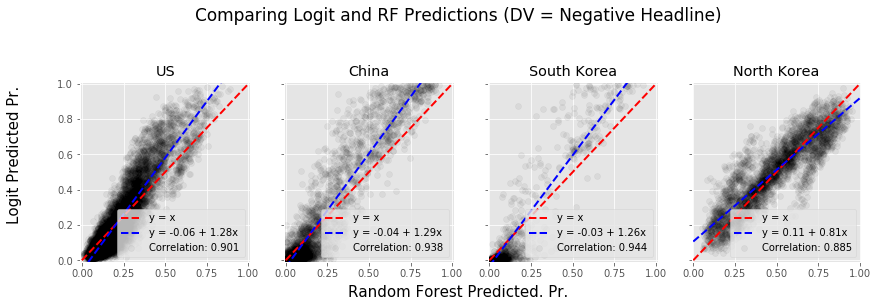

In [136]:
## Scatter Plot & Regression Lines (Negative Coding)

plt.rcParams["figure.figsize"] = (14,4)
f, (ax1, ax2, ax3, ax4),  = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.75)
f.text(0.5, 0.98, 'Comparing Logit and RF Predictions (DV = Negative Headline)', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'Random Forest Predicted. Pr.', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'Logit Predicted Pr.', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.scatter(probyav_rf_us_neg, probyav_logit_us_neg, color = 'k', alpha=0.05, 
            label = 'Correlation: %0.3f' % corprobs_us_neg)
ax1.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', label = 'y = x')
ax1.plot([0, 1], [fitprobs_us_neg[1], fitprobs_us_neg[0] + fitprobs_us_neg[1]], color='b', lw=2, 
         linestyle='--', label = 'y = %0.2f + %0.2fx ' %(fitprobs_us_neg[1],fitprobs_us_neg[0]))
ax1.set_title('US');
ax1.set_xlim(-0.01,1.01)
ax1.set_ylim(-0.01,1.01)
ax1.legend(loc="lower right")

ax2.scatter(probyav_rf_chn_neg, probyav_logit_chn_neg, color = 'k', alpha=0.05, 
            label = 'Correlation: %0.3f' % corprobs_chn_neg)
ax2.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', label = 'y = x')
ax2.plot([0, 1], [fitprobs_chn_neg[1], fitprobs_chn_neg[0] + fitprobs_chn_neg[1]], color='b', lw=2, 
         linestyle='--', label = 'y = %0.2f + %0.2fx ' %(fitprobs_chn_neg[1],fitprobs_chn_neg[0]))
ax2.set_title('China');
ax2.set_xlim(-0.01,1.01)
ax2.set_ylim(-0.01,1.01)
ax2.legend(loc="lower right")

ax3.scatter(probyav_rf_sko_neg, probyav_logit_sko_neg, color = 'k', alpha=0.05, 
            label = 'Correlation: %0.3f' % corprobs_sko_neg)
ax3.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', label = 'y = x')
ax3.plot([0, 1], [fitprobs_sko_neg[1], fitprobs_sko_neg[0] + fitprobs_sko_neg[1]], color='b', lw=2, 
         linestyle='--', label = 'y = %0.2f + %0.2fx ' %(fitprobs_sko_neg[1],fitprobs_sko_neg[0]))
ax3.set_title('South Korea');
ax3.set_xlim(-0.01,1.01)
ax3.set_ylim(-0.01,1.01)
ax3.legend(loc="lower right")

ax4.scatter(probyav_rf_nko_neg, probyav_logit_nko_neg, color = 'k', alpha=0.05, 
            label = 'Correlation: %0.3f' % corprobs_nko_neg)
ax4.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', label = 'y = x')
ax4.plot([0, 1], [fitprobs_nko_neg[1], fitprobs_nko_neg[0] + fitprobs_nko_neg[1]], color='b', lw=2, 
         linestyle='--', label = 'y = %0.2f + %0.2fx ' %(fitprobs_nko_neg[1],fitprobs_nko_neg[0]))
ax4.set_title('North Korea');
ax4.set_xlim(-0.01,1.01)
ax4.set_ylim(-0.01,1.01)
ax4.legend(loc="lower right")

plt.show()

In [137]:
# Correlation and Simple Linear Regression (Positive Coding)
corprobs_us_pos = np.corrcoef(probyav_rf_us_pos,probyav_logit_us_pos)[0,1]
fitprobs_us_pos = np.polyfit(probyav_rf_us_pos,probyav_logit_us_pos, deg=1)
corprobs_chn_pos = np.corrcoef(probyav_rf_chn_pos,probyav_logit_chn_pos)[0,1]
fitprobs_chn_pos = np.polyfit(probyav_rf_chn_pos,probyav_logit_chn_pos, deg=1)
corprobs_sko_pos = np.corrcoef(probyav_rf_sko_pos,probyav_logit_sko_pos)[0,1]
fitprobs_sko_pos = np.polyfit(probyav_rf_sko_pos,probyav_logit_sko_pos, deg=1)
corprobs_nko_pos = np.corrcoef(probyav_rf_nko_pos,probyav_logit_nko_pos)[0,1]
fitprobs_nko_pos = np.polyfit(probyav_rf_nko_pos,probyav_logit_nko_pos, deg=1)


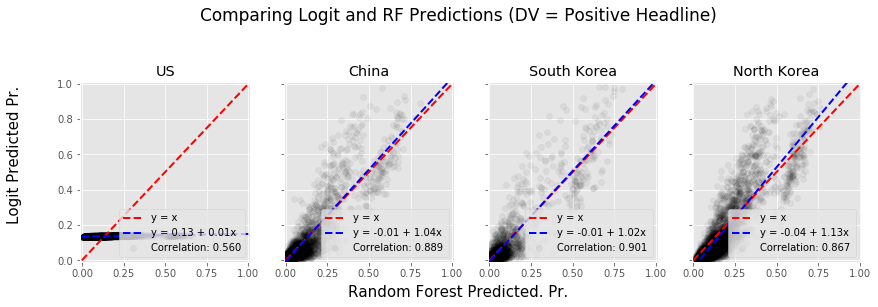

In [138]:
## Scatter Plot & Regression Lines (Positive Coding)
plt.rcParams["figure.figsize"] = (14,4)
f, (ax1, ax2, ax3, ax4),  = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.75)
f.text(0.5, 0.98, 'Comparing Logit and RF Predictions (DV = Positive Headline)', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'Random Forest Predicted. Pr.', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'Logit Predicted Pr.', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.scatter(probyav_rf_us_pos, probyav_logit_us_pos, color = 'k', alpha=0.05, 
            label = 'Correlation: %0.3f' % corprobs_us_pos)
ax1.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', label = 'y = x')
ax1.plot([0, 1], [fitprobs_us_pos[1], fitprobs_us_pos[0] + fitprobs_us_pos[1]], color='b', lw=2, 
         linestyle='--', label = 'y = %0.2f + %0.2fx ' %(fitprobs_us_pos[1],fitprobs_us_pos[0]))
ax1.set_title('US');
ax1.set_xlim(-0.01,1.01)
ax1.set_ylim(-0.01,1.01)
ax1.legend(loc="lower right")

ax2.scatter(probyav_rf_chn_pos, probyav_logit_chn_pos, color = 'k', alpha=0.05, 
            label = 'Correlation: %0.3f' % corprobs_chn_pos)
ax2.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', label = 'y = x')
ax2.plot([0, 1], [fitprobs_chn_pos[1], fitprobs_chn_pos[0] + fitprobs_chn_pos[1]], color='b', lw=2, 
         linestyle='--', label = 'y = %0.2f + %0.2fx ' %(fitprobs_chn_pos[1],fitprobs_chn_pos[0]))
ax2.set_title('China');
ax2.set_xlim(-0.01,1.01)
ax2.set_ylim(-0.01,1.01)
ax2.legend(loc="lower right")

ax3.scatter(probyav_rf_sko_pos, probyav_logit_sko_pos, color = 'k', alpha=0.05, 
            label = 'Correlation: %0.3f' % corprobs_sko_pos)
ax3.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', label = 'y = x')
ax3.plot([0, 1], [fitprobs_sko_pos[1], fitprobs_sko_pos[0] + fitprobs_sko_pos[1]], color='b', lw=2, 
         linestyle='--', label = 'y = %0.2f + %0.2fx ' %(fitprobs_sko_pos[1],fitprobs_sko_pos[0]))
ax3.set_title('South Korea');
ax3.set_xlim(-0.01,1.01)
ax3.set_ylim(-0.01,1.01)
ax3.legend(loc="lower right")

ax4.scatter(probyav_rf_nko_pos, probyav_logit_nko_pos, color = 'k', alpha=0.05, 
            label = 'Correlation: %0.3f' % corprobs_nko_pos)
ax4.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', label = 'y = x')
ax4.plot([0, 1], [fitprobs_nko_pos[1], fitprobs_nko_pos[0] + fitprobs_nko_pos[1]], color='b', lw=2, 
         linestyle='--', label = 'y = %0.2f + %0.2fx ' %(fitprobs_nko_pos[1],fitprobs_nko_pos[0]))
ax4.set_title('North Korea');
ax4.set_xlim(-0.01,1.01)
ax4.set_ylim(-0.01,1.01)
ax4.legend(loc="lower right")

plt.show()


#### 4.2.2 Uncertainty in Predictions

The table below shows standard errors from simulations from 1000 bootstrapped samples averaged by cases. It shows that random forest method have 0.05 smaller average standard error than logit. It confirms the expectation that the nature of random forest as ensemble method reduces the variance in predictions.   

In [139]:
######################################
## 4.2.2 Uncertainty in Predictions ##
######################################

pd.DataFrame({'Logit':np.array([np.mean(np.std(proby_logit_us_neg, axis = 1)),
                               np.mean(np.std(proby_logit_chn_neg, axis = 1)),
                               np.mean(np.std(proby_logit_sko_neg, axis = 1)),
                               np.mean(np.std(proby_logit_nko_neg, axis = 1)),
                               np.mean(np.std(proby_logit_us_pos, axis = 1)),
                               np.mean(np.std(proby_logit_chn_pos, axis = 1)),
                               np.mean(np.std(proby_logit_sko_pos, axis = 1)),
                               np.mean(np.std(proby_logit_nko_pos, axis = 1))]
                               ),
             'Random Forest':np.array([np.mean(np.std(proby_rf_us_neg, axis = 1)),
                               np.mean(np.std(proby_rf_chn_neg, axis = 1)),
                               np.mean(np.std(proby_rf_sko_neg, axis = 1)),
                               np.mean(np.std(proby_rf_nko_neg, axis = 1)),
                               np.mean(np.std(proby_rf_us_pos, axis = 1)),
                               np.mean(np.std(proby_rf_chn_pos, axis = 1)),
                               np.mean(np.std(proby_rf_sko_pos, axis = 1)),
                               np.mean(np.std(proby_rf_nko_pos, axis = 1))]
                                     )}, 
             index = ['Av.SE (US: Negative)','Av.SE (China: Negative)','Av.SE (S.Korea: Negative)','Av.SE (N.Korea: Negative)',
                      'Av.SE (US: Positive)','Av.SE (China: Positive)','Av.SE (S.Korea: Positive)','Av.SE (N.Korea: Positive)'], 
             columns = ['Logit','Random Forest']) #.transpose()


Logit  Random Forest
Av.SE (US: Negative)       0.092435       0.061003
Av.SE (China: Negative)    0.100520       0.073777
Av.SE (S.Korea: Negative)  0.048278       0.049512
Av.SE (N.Korea: Negative)  0.062494       0.086600
Av.SE (US: Positive)       0.010804       0.043738
Av.SE (China: Positive)    0.044606       0.047252
Av.SE (S.Korea: Positive)  0.040374       0.047420
Av.SE (N.Korea: Positive)  0.076384       0.062716

## 5. Export Result as CSV file

* Average predicted proabability are stored as new variables --- <code>logit_pred</code> for logistic regression prediction and <code>rf_pred</code> for random forest prediction --- in <code>..data</code> dataset. 

In [140]:
######################
## 5 Export Results ##
######################

## Test Set Prediction Files
uspred_test = pd.DataFrame({'y_test_neg':y_test_us_neg,
                            'proby_test_logit_neg':proby_test_logit_us_neg,
                            'proby_test_rf_neg':proby_test_rf_us_neg,
                            'y_test_pos':y_test_us_pos,
                            'proby_test_logit_pos': proby_test_logit_us_pos,
                            'proby_test_rf_pos': proby_test_rf_us_pos})
chnpred_test = pd.DataFrame({'y_test_neg':y_test_chn_neg,
                             'proby_test_logit_neg':proby_test_logit_chn_neg,
                             'proby_test_rf_neg':proby_test_rf_chn_neg,
                            'y_test_pos':y_test_chn_pos,
                            'proby_test_logit_pos': proby_test_logit_chn_pos,
                            'proby_test_rf_pos': proby_test_rf_chn_pos})
skopred_test = pd.DataFrame({'y_test_neg':y_test_sko_neg,
                             'proby_test_logit_neg':proby_test_logit_sko_neg,
                             'proby_test_rf_neg':proby_test_rf_sko_neg,
                            'y_test_pos':y_test_sko_pos,
                            'proby_test_logit_pos': proby_test_logit_sko_pos,
                            'proby_test_rf_pos': proby_test_rf_sko_pos})
nkopred_test = pd.DataFrame({'y_test_neg':y_test_nko_neg,
                             'proby_test_logit_neg':proby_test_logit_nko_neg,
                             'proby_test_rf_neg':proby_test_rf_nko_neg,
                            'y_test_pos':y_test_nko_pos,
                            'proby_test_logit_pos': proby_test_logit_nko_pos,
                            'proby_test_rf_pos': proby_test_rf_nko_pos})
## Save Them
uspred_test.to_csv(path_or_buf = '../data/uspred_test.csv', encoding='CP932')
chnpred_test.to_csv(path_or_buf = '..data/chnpred_test.csv', encoding='CP932')
skopred_test.to_csv(path_or_buf = '../data/skopred_test.csv', encoding='CP932')
nkopred_test.to_csv(path_or_buf = '../data/nkopred_test.csv', encoding='CP932')


In [141]:
start = trec()

## Save Average Coding
usdata['logitpr_neg'] = probyav_logit_us_neg
usdata['rfpr_neg'] = probyav_rf_us_neg
usdata['logitpr_pos'] = probyav_logit_us_pos
usdata['rfpr_pos'] = probyav_rf_us_pos
usdata.to_csv(path_or_buf = '../data/usdata_codepred.csv', encoding='CP932')

time_saveav = trec() - start
print('Computation time is %0.3f seconds' % time_saveav)


Computation time is 0.795 seconds


In [142]:
start = trec()

## Save Average Coding
chndata['logitpr_neg'] = probyav_logit_chn_neg
chndata['rfpr_neg'] = probyav_rf_chn_neg
chndata['logitpr_pos'] = probyav_logit_chn_pos
chndata['rfpr_pos'] = probyav_rf_chn_pos
chndata.to_csv(path_or_buf = '../data/chndata_codepred.csv', encoding='CP932')

time_saveav = trec() - start
print('Computation time is %0.3f seconds' % time_saveav)


Computation time is 0.310 seconds


In [143]:
start = trec()

## Save Average Coding
skodata['logitpr_neg'] = probyav_logit_sko_neg
skodata['rfpr_neg'] = probyav_rf_sko_neg
skodata['logitpr_pos'] = probyav_logit_sko_pos
skodata['rfpr_pos'] = probyav_rf_sko_pos
skodata.to_csv(path_or_buf = '../data/skodata_codepred.csv', encoding='CP932')

time_saveav = trec() - start
print('Computation time is %0.3f seconds' % time_saveav)


Computation time is 0.195 seconds


In [144]:
start = trec()

## Save Average Coding
nkodata['logitpr_neg'] = probyav_logit_nko_neg
nkodata['rfpr_neg'] = probyav_rf_nko_neg
nkodata['logitpr_pos'] = probyav_logit_nko_pos
nkodata['rfpr_pos'] = probyav_rf_nko_pos
nkodata.to_csv(path_or_buf = '../data/nkodata_codepred.csv', encoding='CP932')

time_saveav = trec() - start
print('Computation time is %0.3f seconds' % time_saveav)


Computation time is 0.418 seconds


In [145]:
start = trec()

## Save Logit Prediction Simulation
np.savetxt('../data_heavy/logitpred_sim_us_neg.csv.gz', proby_logit_us_neg)
np.savetxt('../data_heavy/logitpred_sim_chn_neg.csv.gz', proby_logit_chn_neg)
np.savetxt('../data_heavy/logitpred_sim_sko_neg.csv.gz', proby_logit_sko_neg)
np.savetxt('../data_heavy/logitpred_sim_nko_neg.csv.gz', proby_logit_nko_neg)
np.savetxt('../data_heavy/logitpred_sim_us_pos.csv.gz', proby_logit_us_pos)
np.savetxt('../data_heavy/logitpred_sim_chn_pos.csv.gz', proby_logit_chn_pos)
np.savetxt('../data_heavy/logitpred_sim_sko_pos.csv.gz', proby_logit_sko_pos)
np.savetxt('../data_heavy/logitpred_sim_nko_pos.csv.gz', proby_logit_nko_pos)

time_saveprobylogit = trec() - start
print('Computation time is %0.3f seconds' % time_saveprobylogit)


Computation time is 137.376 seconds


In [146]:
start = trec()

## Save Random Forest Prediction Simulation
np.savetxt('../data_heavy/rfpred_sim_us_neg.csv.gz', proby_rf_us_neg)
np.savetxt('../data_heavy/rfpred_sim_chn_neg.csv.gz', proby_rf_chn_neg)
np.savetxt('../data_heavy/rfpred_sim_sko_neg.csv.gz', proby_rf_sko_neg)
np.savetxt('../data_heavy/rfpred_sim_nko_neg.csv.gz', proby_rf_nko_neg)
np.savetxt('../data_heavy/rfpred_sim_us_pos.csv.gz', proby_rf_us_pos)
np.savetxt('../data_heavy/rfpred_sim_chn_pos.csv.gz', proby_rf_chn_pos)
np.savetxt('../data_heavy/rfpred_sim_sko_pos.csv.gz', proby_rf_sko_pos)
np.savetxt('../data_heavy/rfpred_sim_nko_pos.csv.gz', proby_rf_nko_pos)

time_saveprobyrf = trec() - start
print('Computation time is %0.3f seconds' % time_saveprobyrf)

Computation time is 168.051 seconds
